In [ ]:
# !pip install category_encoders
# !pip3 install pdpbox==0.2
# !pip3 install xgboost==1.7.2
# !pip install eli5

 ## 파일 먼저 불러오기

### 문제 정의 및 데이터 선정 이유

> 해결하고자 하는 문제를 구체적인 상황으로 제시
  
    영화제작사(고객사)로 부터 흑자를 내기 위한 다음 아이템 예측 모델(장르,감독 등을 조정)을 의뢰받음
    영화 제작사의 규모는 직원 27명의 중소기업으로, 지난 2022년 1년동안 영화3편, 시리즈물 1편(30분짜리 12부작)을 제작함
    ((주)에이스메이커무비웍스 제작사를 참고함)
    2023년 하반기 영화 2편 제작을 계획 중에 있음

> 데이터셋 선정이 끝났다면 어떤 유형의 문제로 (분류 / **회귀**) 접근할지 결정합니다.
  
    수익을 예측(회귀모델)하고, 예산보다 수익이 크게 나오기 위해 어떤 변수(장르, 제목 등등)를 조정해야 할지 결정

> 타겟 선정

    데이터셋의 revenue(수익)컬럼

> 타겟을 잘 설명할 수 있을 만한 특성에 대한 가설을 설정합니다.

    장르에 따른 선호도가 존재할 것이다
    출연작이 많은 배우의 흥행률이 높을 것이다
    제목이 짧은 영화가 관객들의 선택을 받기 쉬울 것이다
    상영시간이 분포의 중앙에 위치해야 수익이 높을 것이다
    예산을 많이 들이면 수익이 클 것이다
    외출하기 좋은 계절(봄, 가을)에 수익이 클 것이다

* 영화 제작 사정마다 조정할 수 있는 요소들이 다를 것이고, **최선의 선택을 하게끔(그래서 흑자로 이어질 수 있게끔) 예측해주는 것이 내가 해야할 일**




### 데이터 전처리, EDA, 시각화

#### 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option("display.float_format", '{:,.3f}'.format) # 지수로 display되지 않도록

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/tmdb_5000_movies.csv")
movie = df.copy() # 사본 만들기
# 배우 감독 데이터 불러오기
df2 = pd.read_csv('/content/drive/MyDrive/data/tmdb_5000_credits.csv')
cast = df2.copy() # 사본 만들기
cast.rename(columns={'movie_id':'id'}, inplace=True) # movie 데이터셋과 id 이름 통일

# movie_id로 left join(movie데이터 살리기)하여 cast컬럼 합치기
movie = pd.merge(movie, cast[['cast','id']], how='left', on='id')
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

#### 중복 데이터 확인

In [ ]:
movie.duplicated().sum()

0

In [ ]:
movie.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.438,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.000,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.200,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.083,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.000,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.900,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.377,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,2015-10-26,880674609,148.000,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.300,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.313,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,2012-07-16,1084939099,165.000,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.600,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.927,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,2012-03-07,284139100,132.000,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.100,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


#### 학습과 무관한 컬럼 제거

* 미래에 알 수 있는 데이터
* 텍스트 데이터
* 고유값 데이터

In [ ]:
# 사용할 컬럼 선택
dels = ['homepage', 'id','keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'status', 'tagline', 'vote_average','vote_count']
movie.drop(columns=dels, inplace=True)
movie.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   budget            4803 non-null   int64  
 1   genres            4803 non-null   object 
 2   release_date      4802 non-null   object 
 3   revenue           4803 non-null   int64  
 4   runtime           4801 non-null   float64
 5   spoken_languages  4803 non-null   object 
 6   title             4803 non-null   object 
 7   cast              4803 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 300.3+ KB


#### 결측치 확인

In [ ]:
movie.isnull().sum()

budget              0
genres              0
release_date        1
revenue             0
runtime             2
spoken_languages    0
title               0
cast                0
dtype: int64

In [ ]:
# drop = movie.loc[movie.release_date.isnull()]
# movie.drop(drop.index, axis=0, inplace=True)
# movie.reset_index(drop=True, inplace=True)
# movie.head()

##### runtime 결측치

In [ ]:
# runtime 결측치 확인
movie.loc[movie.runtime.isnull()]

,budget,genres,release_date,revenue,runtime,spoken_languages,title,cast
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Chiamatemi Francesco - Il Papa della gente,"[{""cast_id"": 5, ""character"": ""Jorge Mario Berg..."
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",2015-12-12,0,NaN,[],"To Be Frank, Sinatra at 100","[{""cast_id"": 0, ""character"": ""Narrator"", ""cred..."


In [ ]:
# 검색해서 값 채워줌
movie.loc[2656, 'runtime'] = 113
movie.loc[4140, 'runtime'] = 81

In [ ]:
# 반올림해서 int형으로 데이터타입 변환
movie.runtime = movie.runtime.round().astype(int)

In [ ]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   budget            4803 non-null   int64 
 1   genres            4803 non-null   object
 2   release_date      4802 non-null   object
 3   revenue           4803 non-null   int64 
 4   runtime           4803 non-null   int64 
 5   spoken_languages  4803 non-null   object
 6   title             4803 non-null   object
 7   cast              4803 non-null   object
dtypes: int64(3), object(5)
memory usage: 300.3+ KB


#### 이상치 확인(수치형)

결측치와 같은 이상치(0으로 적힌 값) 처리

In [ ]:
movie.describe()

,budget,revenue,runtime
count,"4,803.000","4,803.000","4,803.000"
mean,"29,045,039.875","82,260,638.652",106.872
std,"40,722,391.259","162,857,100.943",22.610
min,0.000,0.000,0.000
25%,"790,000.000",0.000,94.000
50%,"15,000,000.000","19,170,001.000",103.000
75%,"40,000,000.000","92,917,187.000",117.500
max,"380,000,000.000","2,787,965,087.000",338.000


##### 수익만 0인 데이터

수익만 0인 데이터는 수가 많아서 검색하지 않고 미래에 고객이 제작을 염두에 두고 있는 영화에 대한 정보라고 가정하고 분리해둠

In [ ]:
future = movie.query("runtime!=0 and revenue==0 and budget!=0")
movie_list = future.copy()
train = movie.drop(future.index, axis=0)
train.reset_index(drop=True, inplace=True)
movie_list.info()
movie_list.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 535 entries, 83 to 4799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   budget            535 non-null    int64 
 1   genres            535 non-null    object
 2   release_date      535 non-null    object
 3   revenue           535 non-null    int64 
 4   runtime           535 non-null    int64 
 5   spoken_languages  535 non-null    object
 6   title             535 non-null    object
 7   cast              535 non-null    object
dtypes: int64(3), object(5)
memory usage: 37.6+ KB


##### 예산만 0인 데이터

데이터 크기가 작아서 최대한 검색해서 채워주고 찾지 못한 데이터는 평균값으로 채워줌

In [ ]:
bud_mean = train.budget.mean().round()
bud_mean

30758834.0

In [ ]:
# 예산만 0인 데이터

len(train.loc[(train.budget==0) & (train.revenue!=0) & (train.runtime!=0)])
budget = [95, 90, 12, 30, 85, 60, 60, 55, 55, 51, 40.6, 130, 42, 25, 39,\
          35, 32, 31, 30, 30, 30, 30, 30, 20, 80, 25, 20, 25, 21, 20, 20, 33,\
          20, 20, 20, 19, 25, 1.5, 18, 17.5, 17, 15, 14, 130, 12, 12.8, 12, 12,\
          12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 9, 9, 7.2, 8.5,\
          45, 8, 8, 8, 8, 7.9, 10, 7.2, 24, 7, 6.9, 7, 5.25, 6.5, 5.6, 3.64, 9,\
          5, 4.5, 4, 3, 4, 4, 3.3, 7, 3.2, 3.75, 3, 3, 26, 2.5, 2.5, 2.3,\
          2.1, 2, 2, 2, 1.5, 1.9, 1.5, 1.7, 1.6, 1.5, 1.2, 1.5, 4, 1, 1, 1,\
          0.6, 1, 1, 0.5, 0.9, 0.84, 1, 0.42, 0.27, 3]
miss_bud = train.query("title in ['Carriers', 'Our Kind of Traitor', 'Mr. Turner', 'Girl with a Pearl Earring',\
                 'O', 'Romance & Cigarettes', 'Michael Jordan to the Max', 'Control',\
                 'Khiladi 786', 'Irreversible', 'Blackthorn', 'What the #$*! Do We (K)now!?',\
                 'The Geographer Drank His Globe Away', 'Adam', 'Water', 'Touching the Void',\
                 'ABCD (Any Body Can Dance)', 'Eddie: The Sleepwalking Cannibal', 'Good Kill',\
                 'Bloody Sunday', 'My Dog Tulip', 'Dogtooth', 'Three', 'The Last Waltz']")
for loc in miss_bud.index:
  train.loc[loc, 'budget'] = bud_mean
# 예산 찾아서 채워넣기
index = train.loc[(train.revenue != 0) & (train.budget == 0) & (train.runtime != 0)].index
for i in range(len(budget)):
  train.loc[index[i], 'budget'] = budget[i]*1000000

print(f"결측치가 0인가?: {len(train.loc[(train.revenue != 0) & (train.budget == 0) & (train.runtime != 0)])}개")

결측치가 0인가?: 0개


##### 나머지 0이 담긴 데이터

budget, runtime이 모두 0인 데이터 모두 평균값으로 채워줌

In [ ]:
run_mean =train.runtime.mean().round()

for i in range(len(train)):
  if train.loc[i, 'budget'] == 0:
    train.loc[i, 'budget'] = bud_mean
  if train.loc[i, 'runtime'] == 0:
    train.loc[i, 'runtime'] = run_mean
train.query('budget==0 | runtime==0')

,budget,genres,release_date,revenue,runtime,spoken_languages,title,cast


In [ ]:
train.describe()

,budget,revenue,runtime
count,"4,268.000","4,268.000","4,268.000"
mean,"37,867,667.593","92,572,129.204",108.464
std,"39,192,163.809","169,979,586.804",21.046
min,1.000,0.000,14.000
25%,"14,000,000.000","780,932.250",94.000
50%,"30,758,834.000","29,400,000.000",105.000
75%,"42,000,000.000","105,943,409.750",118.000
max,"380,000,000.000","2,787,965,087.000",338.000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4268 entries, 0 to 4267
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   budget            4268 non-null   int64 
 1   genres            4268 non-null   object
 2   release_date      4267 non-null   object
 3   revenue           4268 non-null   int64 
 4   runtime           4268 non-null   int64 
 5   spoken_languages  4268 non-null   object
 6   title             4268 non-null   object
 7   cast              4268 non-null   object
dtypes: int64(3), object(5)
memory usage: 266.9+ KB


In [ ]:
rev_mean =train.revenue.mean().round()

for i in range(len(train)):
  if train.loc[i, 'revenue'] == 0:
    train.loc[i, 'revenue'] = rev_mean
train.query('revenue==0')

,budget,genres,release_date,revenue,runtime,spoken_languages,title,cast


In [ ]:
train.describe()

,budget,revenue,runtime
count,"4,268.000","4,268.000","4,268.000"
mean,"37,867,667.593","111,919,443.888",108.464
std,"39,192,163.809","163,484,591.824",21.046
min,1.000,5.000,14.000
25%,"14,000,000.000","22,135,275.250",94.000
50%,"30,758,834.000","89,226,036.000",105.000
75%,"42,000,000.000","105,943,409.750",118.000
max,"380,000,000.000","2,787,965,087.000",338.000


##### 데이터 분포 확인하기

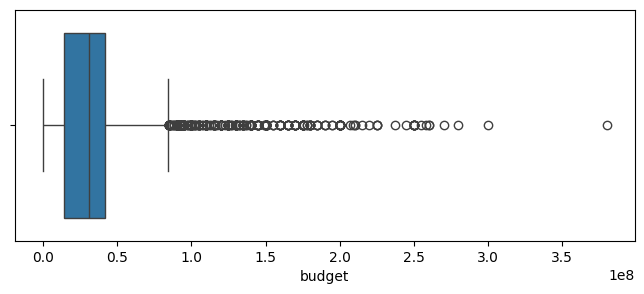

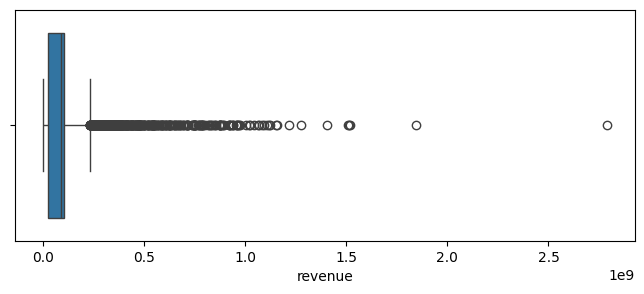

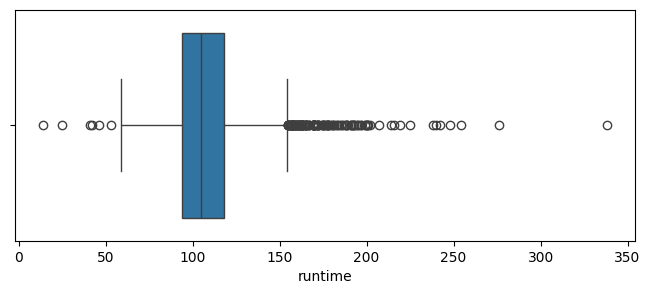

In [ ]:
# 수치형 데이터 분포 확인하기 plot()
numeric = ['budget', 'revenue', 'runtime']
def box_plot(x):
  plt.figure(figsize=(8,3))
  sns.boxplot(x=x)
  plt.show();
for col in numeric:
  median = train[col]
  x = train.loc[:, col]
  box_plot(x)

##### revenue 이상치

In [ ]:
# 수익 최대값 기준 10**6 곱해주기
less_rev = train.loc[train.revenue < 2787].index
for index in less_rev:
  train.loc[index, 'revenue'] = train.loc[index, 'revenue'] * 1000000
train.describe()

,budget,revenue,runtime
count,"4,268.000","4,268.000","4,268.000"
mean,"37,867,667.593","112,681,158.215",108.464
std,"39,192,163.809","165,369,374.970",21.046
min,1.000,"3,330.000",14.000
25%,"14,000,000.000","22,559,184.000",94.000
50%,"30,758,834.000","89,796,251.000",105.000
75%,"42,000,000.000","107,153,673.750",118.000
max,"380,000,000.000","2,787,965,087.000",338.000


In [ ]:
train.loc[train.revenue < 20000]

,budget,genres,release_date,revenue,runtime,spoken_languages,title,cast
1879,25000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 12, ""na...",2013-12-05,6399,99,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Adventurer: The Curse of the Midas Box,"[{""cast_id"": 1, ""character"": ""Mariah Mundi"", ""..."
2682,20000000,"[{""id"": 10752, ""name"": ""War""}, {""id"": 18, ""nam...",2011-04-14,17479,113,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",5 Days of War,"[{""cast_id"": 2, ""character"": ""Thomas Anders"", ..."
2873,10000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 53, ""name...",2015-07-01,17472,111,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Strangerland,"[{""cast_id"": 1, ""character"": ""Catherine Parker..."
2874,10000000,"[{""id"": 35, ""name"": ""Comedy""}]",2009-10-16,9069,85,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Janky Promoters,"[{""cast_id"": 1, ""character"": ""Russell Redds"", ..."
3448,3800000,"[{""id"": 10752, ""name"": ""War""}, {""id"": 37, ""nam...",1965-04-07,14873,123,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Major Dundee,"[{""cast_id"": 1, ""character"": ""Major Amos Charl..."
3659,2100000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",2015-10-16,3330,126,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}, ...",Mi America,"[{""cast_id"": 6, ""character"": ""Roe Ramirez"", ""c..."
3927,500000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 53, ""nam...",2010-07-01,14870,93,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Perfect Host,"[{""cast_id"": 1, ""character"": ""Warwick Wilson"",..."
3932,1000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",2006-04-28,10018,78,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Alone With Her,"[{""cast_id"": 3, ""character"": ""Doug"", ""credit_i..."
3933,1000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 14, ""name...",2006-01-30,7202,81,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Special,"[{""cast_id"": 5, ""character"": ""Les"", ""credit_id..."
4003,700000,"[{""id"": 18, ""name"": ""Drama""}]",1999-10-08,10508,107,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Naturally Native,"[{""cast_id"": 0, ""character"": ""Vickie Lewis Big..."


In [ ]:
# 애매한 데이터는 검색해보고 수정해줌
fill_rev = [(1879, 128471), (2682, 316944), (2873, 161097), (3927, 453708), (3932, 1677967)]
for index, revenue in fill_rev:
  train.loc[index, 'revenue'] = revenue
train.describe()

,budget,revenue,runtime
count,"4,268.000","4,268.000","4,268.000"
mean,"37,867,667.593","112,681,784.257",108.464
std,"39,192,163.809","165,368,950.530",21.046
min,1.000,"3,330.000",14.000
25%,"14,000,000.000","22,559,184.000",94.000
50%,"30,758,834.000","89,796,251.000",105.000
75%,"42,000,000.000","107,153,673.750",118.000
max,"380,000,000.000","2,787,965,087.000",338.000


##### 예산 이상치

In [ ]:
# 10**6 곱해줄 데이터
train.loc[train.budget < 380]

,budget,genres,release_date,revenue,runtime,spoken_languages,title,cast
1480,30,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 16, ""...",2000-09-14,103000000,78,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Rugrats in Paris: The Movie,"[{""cast_id"": 1, ""character"": ""Tommy Pickles (v..."
1672,28,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 28, ""n...",2001-12-07,14000000,93,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The 51st State,"[{""cast_id"": 1, ""character"": ""Elmo McElroy"", ""..."
1803,25,"[{""id"": 18, ""name"": ""Drama""}]",1999-12-25,13000000,145,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Angela's Ashes,"[{""cast_id"": 1, ""character"": ""Angela McCourt"",..."
2710,11,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",1978-04-26,11000000,145,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",F.I.S.T.,"[{""cast_id"": 3, ""character"": ""Johnny Kovak"", ""..."
2880,10,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",2013-08-30,11000000,85,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Of Horses and Men,"[{""cast_id"": 1, ""character"": ""Kolbeinn"", ""cred..."
2884,10,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 53, ""nam...",2013-09-28,10000000,99,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Nurse 3-D,"[{""cast_id"": 5, ""character"": ""Abby Russell"", ""..."
3077,7,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 28, ""n...",1992-05-01,5000000,90,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Split Second,"[{""cast_id"": 1, ""character"": ""Harley Stone"", ""..."
3112,7,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",2009-08-09,7000000,82,[],Bran Nue Dae,"[{""cast_id"": 1, ""character"": ""Willie"", ""credit..."
3285,4,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",1932-12-08,25000000,89,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",A Farewell to Arms,"[{""cast_id"": 1, ""character"": ""Catherine Barkle..."
3811,1,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",1936-02-05,8500000,87,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Modern Times,"[{""cast_id"": 8, ""character"": ""A factory worker..."


In [ ]:
# 예산이 million 단위로 보이는 380미만(최댓값 기준) 데이터는 1000000 곱하기
less_bud = train.query("budget < 380").index
for index in less_bud:
  train.loc[index, 'budget'] = train.loc[index, 'budget'] * 10**6
train.describe()

,budget,revenue,runtime
count,"4,268.000","4,268.000","4,268.000"
mean,"38,010,357.235","112,681,784.257",108.464
std,"39,390,853.342","165,368,950.530",21.046
min,"7,000.000","3,330.000",14.000
25%,"14,000,000.000","22,559,184.000",94.000
50%,"30,758,834.000","89,796,251.000",105.000
75%,"42,000,000.000","107,153,673.750",118.000
max,"380,000,000.000","2,787,965,087.000",338.000


In [ ]:
train.loc[(train.budget >= 1000) & (train.budget < 60000)]

,budget,genres,release_date,revenue,runtime,spoken_languages,title,cast
4076,15000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",2007-09-14,193355800,86,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Paranormal Activity,"[{""cast_id"": 3, ""character"": ""Katie"", ""credit_..."
4178,8000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",2011-09-22,469947,96,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Weekend,"[{""cast_id"": 1000, ""character"": ""Russell"", ""cr..."
4203,10000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 14, ""name...",1977-03-19,7000000,89,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Eraserhead,"[{""cast_id"": 13, ""character"": ""Henry Spencer"",..."
4241,31192,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",2009-09-01,10000,89,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Down Terrace,"[{""cast_id"": 4, ""character"": ""Bill"", ""credit_i..."
4242,27000,"[{""id"": 35, ""name"": ""Comedy""}]",1994-09-13,3151130,92,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Clerks,"[{""cast_id"": 7, ""character"": ""Dante Hicks"", ""c..."
4255,12000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 35, ""nam...",1972-03-12,6000000,93,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Pink Flamingos,"[{""cast_id"": 8, ""character"": ""Divine / Babs Jo..."
4258,20000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 27, ""name...",1997-11-06,99000,111,"[{""iso_639_1"": ""ja"", ""name"": ""\u65e5\u672c\u8a...",Cure,"[{""cast_id"": 3, ""character"": ""Kenichi Takabe"",..."
4262,7000,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",2004-10-08,424760,77,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Primer,"[{""cast_id"": 1, ""character"": ""Aaron"", ""credit_..."


In [ ]:
# 검색해서 틀린 값만 수정
train.loc[4178, 'budget'] = 80000
train.loc[4203, 'budget'] = 100000

In [ ]:
train.describe()

,budget,revenue,runtime
count,"4,268.000","4,268.000","4,268.000"
mean,"38,010,395.191","112,681,784.257",108.464
std,"39,390,816.755","165,368,950.530",21.046
min,"7,000.000","3,330.000",14.000
25%,"14,000,000.000","22,559,184.000",94.000
50%,"30,758,834.000","89,796,251.000",105.000
75%,"42,000,000.000","107,153,673.750",118.000
max,"380,000,000.000","2,787,965,087.000",338.000


##### 런타임 이상치


In [ ]:
train.loc[train.runtime == 14]

,budget,genres,release_date,revenue,runtime,spoken_languages,title,cast
3986,30758834,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 878, ""na...",2012-10-28,92572129,14,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Vessel,"[{""cast_id"": 1, ""character"": ""Danny"", ""credit_..."


In [ ]:
# 검색해서 틀린 값만 수정
train.loc[3986, 'runtime'] = 86

In [ ]:
train.describe()

,budget,revenue,runtime
count,"4,268.000","4,268.000","4,268.000"
mean,"38,010,395.191","112,681,784.257",108.481
std,"39,390,816.755","165,368,950.530",20.999
min,"7,000.000","3,330.000",25.000
25%,"14,000,000.000","22,559,184.000",94.000
50%,"30,758,834.000","89,796,251.000",105.000
75%,"42,000,000.000","107,153,673.750",118.000
max,"380,000,000.000","2,787,965,087.000",338.000


##### 컬럼별 이상치로 보이는 최댓값 데이터 확인

In [ ]:
movie.loc[movie.budget == movie.budget.max()]

,budget,genres,release_date,revenue,runtime,spoken_languages,title,cast
17,380000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",2011-05-14,1045713802,136,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Pirates of the Caribbean: On Stranger Tides,"[{""cast_id"": 15, ""character"": ""Captain Jack Sp..."


예산의 max값이 이상치인지 확인 =>

https://en.wikipedia.org/wiki/Pirates_of_the_Caribbean:_On_Stranger_Tides

캐리비안의 해적 시리즈물로 실제 예산이 맞는 것을 확인

In [ ]:
movie.loc[movie.revenue == movie.revenue.max()]

,budget,genres,release_date,revenue,runtime,spoken_languages,title,cast
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",2009-12-10,2787965087,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."


수익의 max값이 이상치인지 확인 =>

https://www.donga.com/news/Culture/article/all/20230307/118201962/1

아바타의 실제 수익인 것으로확인

In [ ]:
movie.loc[movie.runtime == movie.runtime.max()]

,budget,genres,release_date,revenue,runtime,spoken_languages,title,cast
2384,18000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",2010-05-19,871279,338,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Carlos,"[{""cast_id"": 4, ""character"": ""Ilich Ram\u00edr..."


상영시간 max값이 이상치인지 확인 =>

http://www.cine21.com/movie/info/?movie_id=31785

카를로스 실제 상영시간인 것으로확인

#### 이상치 확인(범주형)

##### 딕셔너리 형태의 문자열 분해하기

In [ ]:
print(train.spoken_languages[0])
print(train.cast[0])
print(train.genres[0])

[{"iso_639_1": "en", "name": "English"}, {"iso_639_1": "es", "name": "Espa\u00f1ol"}]
[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id":

In [ ]:
print(train.spoken_languages[0])
print(train.cast[0])
print(train.genres[0])

[{"iso_639_1": "en", "name": "English"}, {"iso_639_1": "es", "name": "Espa\u00f1ol"}]
[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id":

In [ ]:
# 딕셔너리 분해함수 정의
def detect_dict(data, col, key):
  for i in range(len(data)): # eval(문자열): 문자열을 딕셔너리형으로 반환
    if data[col][i] != '[]': # 빈 데이터가 아니라면
      value = eval(data[col][i])[0][key] # 첫번째 값
      data.loc[i, col] = value # 딕셔너리 대신 value값 하나로 대체
  return data

###### genres, cast, spoken language 컬럼 속 value속 첫번째 딕셔너리에서 값을 추출하는 함수정의

In [ ]:
train = detect_dict(train, 'spoken_languages', 'name')
train = detect_dict(train, 'cast', 'name')
train = detect_dict(train, 'genres', 'name')

In [ ]:
movie_list = detect_dict(movie_list, 'spoken_languages', 'name')
movie_list = detect_dict(movie_list, 'cast', 'name')
movie_list = detect_dict(movie_list, 'genres', 'name')

###### spoken_languages 언어가 미국에 과도하게 치우쳐있어 컬럼 삭제

In [ ]:
# language 카디널리티 확인
train.spoken_languages.unique()

array(['English', 'Français', 'Íslenska', 'Română', 'Latin', 'Italiano',
       'Deutsch', 'Español', 'Português', '普通话', '', 'العربية',
       'Afrikaans', '广州话 / 廣州話', 'Dansk', 'Pусский', 'български език',
       'ελληνικά', 'Český', '日本語', 'Esperanto', 'עִבְרִית', 'Український',
       'svenska', 'Eesti', 'हिन्दी', '한국어/조선말', 'ภาษาไทย', '[]', 'Magyar',
       'Hrvatski', 'Nederlands', 'தமிழ்', 'Kiswahili', 'shqip',
       'No Language', 'Galego', 'Bosanski', 'Tiếng Việt', 'বাংলা',
       'Gaeilge', 'Polski', 'Srpski', 'Norsk', '??????',
       'Bahasa indonesia', 'اردو', 'فارسی'], dtype=object)

In [ ]:
# 나라별 분포가 너무 치우쳐있어 컬럼 제거
train.spoken_languages.value_counts()

spoken_languages
English             3669
Français              91
Español               73
[]                    70
Deutsch               53
Italiano              29
العربية               28
普通话                   27
Pусский               27
Český                 26
广州话 / 廣州話             24
日本語                   21
हिन्दी                19
Português             13
                      10
Dansk                  9
Latin                  8
עִבְרִית               6
한국어/조선말                6
ελληνικά               5
Afrikaans              5
svenska                5
Nederlands             4
Română                 4
Magyar                 3
ภาษาไทย                3
Norsk                  3
No Language            2
Kiswahili              2
Polski                 2
தமிழ்                  2
فارسی                  2
Український            2
Hrvatski               1
shqip                  1
Esperanto              1
Galego                 1
Bosanski               1
Tiếng Việt             1
বাংলা   

In [ ]:
train.drop('spoken_languages', axis=1, inplace=True)
movie_list.drop('spoken_languages', axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4268 entries, 0 to 4267
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   budget        4268 non-null   int64 
 1   genres        4268 non-null   object
 2   release_date  4267 non-null   object
 3   revenue       4268 non-null   int64 
 4   runtime       4268 non-null   int64 
 5   title         4268 non-null   object
 6   cast          4268 non-null   object
dtypes: int64(3), object(4)
memory usage: 233.5+ KB


###### genres 컬럼

결측치 제거('[ ]')

In [ ]:
genre_miss = train.loc[train.genres == '[]']
train.drop(genre_miss.index, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4243 entries, 0 to 4242
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   budget        4243 non-null   int64 
 1   genres        4243 non-null   object
 2   release_date  4243 non-null   object
 3   revenue       4243 non-null   int64 
 4   runtime       4243 non-null   int64 
 5   title         4243 non-null   object
 6   cast          4243 non-null   object
dtypes: int64(3), object(4)
memory usage: 232.2+ KB


In [ ]:
# movie_list 셋에서도 제거
empty_genre = movie_list.loc[movie_list.genres == '[]']
movie_list.drop(empty_genre.index, axis=0, inplace=True)
movie_list.reset_index(drop=True, inplace=True)

In [ ]:
# 카디널리티 확인
movie_list.genres.nunique()

19

In [ ]:
movie_list.isnull().sum()

budget          0
genres          0
release_date    0
revenue         0
runtime         0
title           0
cast            0
dtype: int64

#### Feature Engineering






    title : 공백으로 나누어 단어의 개수를 세어 수치형 변수로 변환하기
    cast : 캐스팅 빈도에 따라 순서형 데이터로 변환
    month : release_data컬럼에서 '월' 정보만 추출
    genre : 빈도 순위에 따라 순서형 데이터로 변환

###### title 제목 수로 value 변경

In [ ]:
def count_words(data):
  for i in range(len(data)):
    words = data.loc[i, 'title'].split(' ') # 공백으로 나눠서
    data.loc[i, 'title'] = len(words) # 요소의 개수를 value값으로
  return data
train, movie_list = count_words(train), count_words(movie_list)
train.title.sample(3)

3420    2
1036    2
2517    1
Name: title, dtype: object

In [ ]:
train.title = train.title.astype(int)
movie_list.title = movie_list.title.astype(int)
X_test = movie_list.drop('revenue', axis=1)

###### cast 값이 []인 데이터 삭제확인 후, 출연자가 다른 영화에 출연한 회수에 따라 (0,1,2,3)의 순서형 데이터로 변환해줌



In [ ]:
# cast'[]'인 데이터 삭제
def cast_drop(data):
  empty_cast = data.loc[data.cast == '[]']
  data.drop(empty_cast.index, axis=0,inplace=True)
  data.reset_index(drop=True, inplace=True)
  return data
train, movie_list = cast_drop(train), cast_drop(movie_list)

In [ ]:
# 배우별 출연작 수
cast_counts = train.cast.value_counts()
cast_counts = pd.DataFrame(cast_counts)
cast_counts.reset_index(inplace=True)
cast_counts.columns = ['cast', 'count']
cast_counts

,cast,count
0,Johnny Depp,27
1,Bruce Willis,27
2,Nicolas Cage,26
3,Robert De Niro,26
4,Denzel Washington,26
...,...,...
1867,Michael Ealy,1
1868,Anne-Marie Loop,1
1869,Clifton Collins Jr,1
1870,Jang Dong-gun,1


In [ ]:
# 1-5:0, 5-10:1, 11-20:2, 21-최대:3 순서형 범주로 변경
c_0 = cast_counts.query("count >=1 and count < 6")['cast'] #0
c_1 = cast_counts.query("count >=6 and count < 11")['cast']
c_2 = cast_counts.query("count >=11 and count < 21")['cast']
c_3 = cast_counts.query("count >=21")['cast']
def cast_class(data):
  for i in range(len(data)):
    if data.loc[i, 'cast'] in c_0.values: # 범위 안에 배우가 있으면 0 변경
      data.loc[i, 'cast'] = '0'
    elif data.loc[i, 'cast'] in c_1.values: # 범위 안에 배우가 있으면 1 변경
      data.loc[i, 'cast'] = '1'
    elif data.loc[i, 'cast'] in c_2.values: # 범위 안에 배우가 있으면 2 변경
      data.loc[i, 'cast'] = '2'
    elif data.loc[i, 'cast'] in c_3.values: # 범위 안에 배우가 있으면 3 변경
      data.loc[i, 'cast'] = '3'
    else: # 새로운 배우 데이터가 들어오면
      data.loc[i, 'cast'] = '0'
  return data
train, movie_list = cast_class(train), cast_class(movie_list)
movie_list.cast.unique()

array(['0', '1', '3', '2'], dtype=object)

In [ ]:
# cast컬럼 데이터 타입 int로 변환
train.cast = train.cast.astype(int)
movie_list.cast = movie_list.cast.astype(int)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   budget        4221 non-null   int64 
 1   genres        4221 non-null   object
 2   release_date  4221 non-null   object
 3   revenue       4221 non-null   int64 
 4   runtime       4221 non-null   int64 
 5   title         4221 non-null   int64 
 6   cast          4221 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 231.0+ KB


###### month 컬럼 만들기

In [ ]:
movie_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   budget        527 non-null    int64 
 1   genres        527 non-null    object
 2   release_date  527 non-null    object
 3   revenue       527 non-null    int64 
 4   runtime       527 non-null    int64 
 5   title         527 non-null    int64 
 6   cast          527 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 28.9+ KB


In [ ]:
def month_detect(data):
  data['month'] = [''] * len(data)
  for i in range(len(data)):
    y, m, d = data.loc[i, 'release_date'].split('-')
    data.loc[i, 'month'] = int(m)
  data.drop('release_date', axis=1, inplace=True)
  return data
train = month_detect(train)
train.month.head()

0    12
1     5
2    10
3     7
4     3
Name: month, dtype: object

In [ ]:
movie_list = month_detect(movie_list)
movie_list.month.head()

0    2
1    2
2    2
3    4
4    7
Name: month, dtype: object

In [ ]:
train.month = train.month.astype(int)
movie_list.month = movie_list.month.astype(int)
movie_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   budget   527 non-null    int64 
 1   genres   527 non-null    object
 2   revenue  527 non-null    int64 
 3   runtime  527 non-null    int64 
 4   title    527 non-null    int64 
 5   cast     527 non-null    int64 
 6   month    527 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 28.9+ KB


In [ ]:
# # 전처리 끝난 데이터 저장하기
# train.to_csv('train_fillna.csv')
# movie_list.to_csv('movie_list_fillna.csv')

budget, revenue 컬럼 M단위로 수정

In [ ]:
def to_million(data):
  data.budget = data.budget / 10**6
  data.revenue = data.revenue / 10**6
  return data
train = to_million(train)
movie_list = to_million(movie_list)

In [ ]:
train.corr(numeric_only=True).sort_values('revenue', ascending=False)

,budget,revenue,runtime,title,cast,month
revenue,0.693,1.000,0.212,0.093,0.213,0.035
budget,1.000,0.693,0.214,0.064,0.299,0.028
cast,0.299,0.213,0.185,-0.039,1.000,0.083
runtime,0.214,0.212,1.000,-0.022,0.185,0.164
title,0.064,0.093,-0.022,1.000,-0.039,-0.007
month,0.028,0.035,0.164,-0.007,0.083,1.000


###### genre 빈도 순위에 따라 순서형 데이터로 변환

In [ ]:
genre_rank = list(train.groupby('genres').mean()['revenue'].sort_values().index)
genre_rank
genre_dict ={}

for i in range(len(genre_rank)):
  genre_dict[genre_rank[i]] = i
genre_dict

{'Foreign': 0,
 'Documentary': 1,
 'Music': 2,
 'Western': 3,
 'Crime': 4,
 'Drama': 5,
 'Horror': 6,
 'War': 7,
 'Comedy': 8,
 'TV Movie': 9,
 'Romance': 10,
 'History': 11,
 'Thriller': 12,
 'Mystery': 13,
 'Action': 14,
 'Fantasy': 15,
 'Science Fiction': 16,
 'Family': 17,
 'Adventure': 18,
 'Animation': 19}

In [ ]:
def genre_ranker(data):
  rank = []
  for i in range(len(data)):
    key = data.loc[i, 'genres']
    rank.append(genre_dict[key])
  data['genre_rank'] = rank
  return data
train = genre_ranker(train)
movie_list = genre_ranker(movie_list)

In [ ]:
train.head()

,budget,genres,revenue,runtime,title,cast,month,genre_rank
0,237.000,Action,"2,787.965",162,1,0,12,14
1,300.000,Adventure,961.000,169,7,3,5,18
2,245.000,Action,880.675,148,1,1,10,14
3,250.000,Action,"1,084.939",165,4,2,7,14
4,260.000,Action,284.139,132,2,0,3,14


#### 시각화

In [ ]:
# 스피어만 상관계수 확인
from scipy import stats
X=train.drop(['revenue', 'genres'], axis=1)
corr = []
for col in list(X):
  corr.append(stats.pearsonr(train[col], train.revenue)[0])
corr_df = pd.DataFrame([corr], index=['revenue'], columns=list(X))
corr_df

,budget,runtime,title,cast,month,genre_rank
revenue,0.693,0.212,0.093,0.213,0.035,0.307


##### 가설1. 장르에 따른 선호도가 존재할 것이다

**O** : 장르에 따른 선호도가 존재함(Animation, Adventure, Family, SF, Fantasy, Action)


In [ ]:
train.genres.value_counts()

genres
Drama              1059
Comedy              910
Action              683
Adventure           318
Horror              263
Crime               167
Thriller            166
Animation           115
Fantasy             108
Romance              93
Science Fiction      89
Documentary          60
Family               51
Mystery              37
Music                28
Western              25
History              23
War                  22
TV Movie              3
Foreign               1
Name: count, dtype: int64

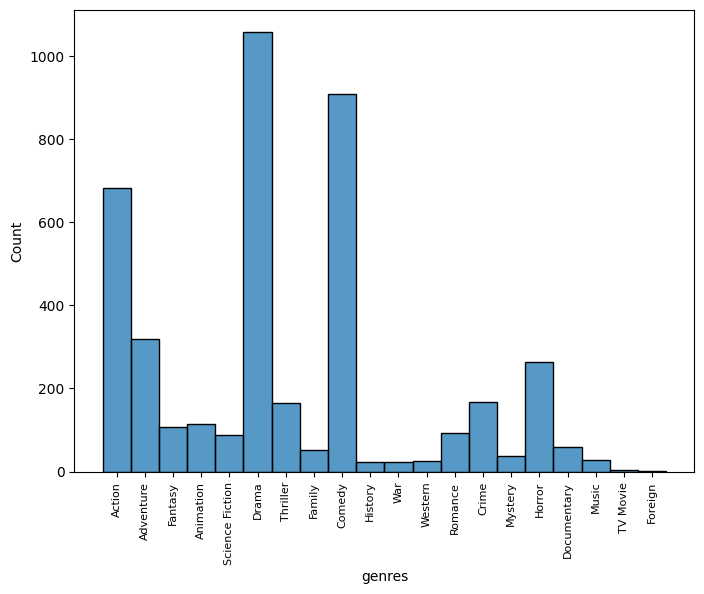

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(train.genres)
plt.xticks(rotation=90, fontsize=8);

In [ ]:
train.genres.value_counts()

genres
Drama              1059
Comedy              910
Action              683
Adventure           318
Horror              263
Crime               167
Thriller            166
Animation           115
Fantasy             108
Romance              93
Science Fiction      89
Documentary          60
Family               51
Mystery              37
Music                28
Western              25
History              23
War                  22
TV Movie              3
Foreign               1
Name: count, dtype: int64

<ipython-input-83-d59e48809b0a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(genre_pivot.sort_values('revenue', ascending=False),x = 'revenue', y = 'genres', palette = palette, edgecolor='black', linewidth=.5)


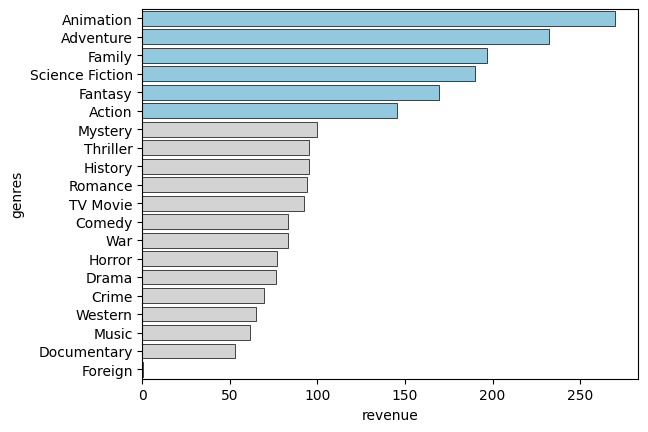

In [ ]:
# 장르(genre)별 수익(revenue) 시각화
genre_pivot = pd.pivot_table(train,
                             index='genres',
                             values='revenue',
                             aggfunc='mean')
genre_pivot.reset_index(inplace=True)
palette = (['skyblue']*6) + ['lightgrey'] * (train.genres.nunique() - 6)

sns.barplot(genre_pivot.sort_values('revenue', ascending=False),x = 'revenue', y = 'genres', palette = palette, edgecolor='black', linewidth=.5)
#plt.xticks(list(genre_dict.keys()))
plt.show();

##### 가설2. 출연작이 많은 배우의 흥행률이 높을 것이다

**O** : 클래스 3의 평균 수익이 가장 높은 것을 확인함

In [ ]:
train.cast.value_counts()

cast
0    2542
1     718
2     675
3     286
Name: count, dtype: int64

<ipython-input-85-d7cb4f8d47dc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(cast_pivot.sort_values('revenue', ascending=False),x = 'cast', y = 'revenue', palette=['lightgrey','lightgrey', 'lightgrey', 'crimson'],\


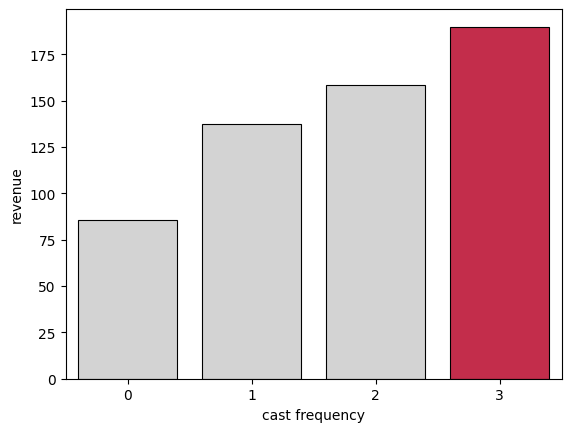

In [ ]:
cast_pivot = pd.pivot_table(train,
                             index='cast',
                             values='revenue',
                             aggfunc='mean')
cast_pivot.reset_index(inplace=True)
sns.barplot(cast_pivot.sort_values('revenue', ascending=False),x = 'cast', y = 'revenue', palette=['lightgrey','lightgrey', 'lightgrey', 'crimson'],\
            edgecolor='black', linewidth=.8)
plt.xlabel('cast frequency')
plt.show();

##### 가설3. 제목이 짧은 영화가 관객들의 선택을 받기 쉬울 것이다

**?** :그래프 상에서는 단어 수가 많을 수록 수익이 크다고 보이지만, 단어 수가 많은 영화의 데이터 수가 워낙 적어서 그런 것으로 추정됨. (참/거짓을 단정짓기 어려움)

In [ ]:
train.title.value_counts()

title
2     1355
3      955
1      877
4      472
5      265
6      152
7       83
8       33
9       13
10      10
13       3
11       1
12       1
15       1
Name: count, dtype: int64

In [ ]:
movie.loc[movie.revenue==748806957].title

63    The Chronicles of Narnia: The Lion, the Witch ...
Name: title, dtype: object

<ipython-input-88-92b9ccbe58b5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(title_pivot.sort_values('revenue', ascending=False),x = 'title', y = 'revenue', palette=palette, edgecolor='black', linewidth=.4)
<ipython-input-88-92b9ccbe58b5>:7: UserWarning: 
The palette list has fewer values (13) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(title_pivot.sort_values('revenue', ascending=False),x = 'title', y = 'revenue', palette=palette, edgecolor='black', linewidth=.4)


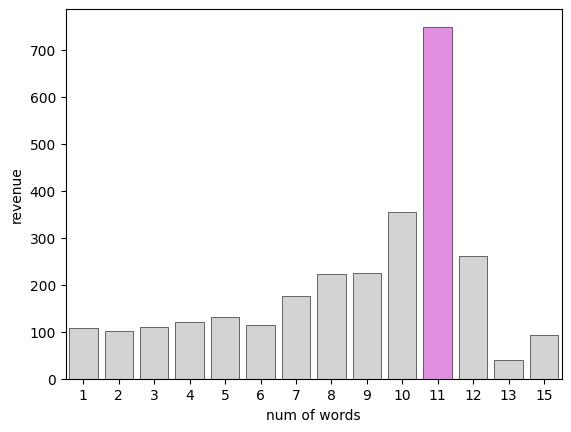

In [ ]:
title_pivot = pd.pivot_table(train,
                             index='title',
                             values='revenue',
                             aggfunc='mean')
title_pivot.reset_index(inplace=True)
palette = (['lightgrey']*10) + ['violet'] + (['lightgrey']*2)
sns.barplot(title_pivot.sort_values('revenue', ascending=False),x = 'title', y = 'revenue', palette=palette, edgecolor='black', linewidth=.4)
plt.xlabel('num of words')
plt.show();

##### 가설4. 상영시간이 분포의 중앙에 위치해야 수익이 높을 것이다

**X** : 150분-200분 사이의 영화가 수익이 가장 높음

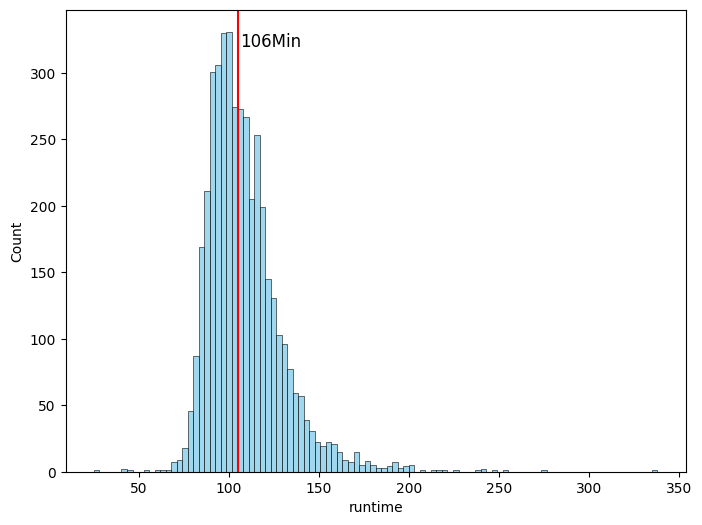

runtime의 중앙값: 105.0분


In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(train, x='runtime',color='skyblue', alpha=.8)
plt.axvline(train.runtime.median(), color='red')
plt.text(106,320,'106Min', fontsize=12)
plt.show();
print(f"runtime의 중앙값: {train.runtime.median()}분")

<ipython-input-90-5affe9294f99>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, palette=palette, edgecolor='black', linewidth=.6)


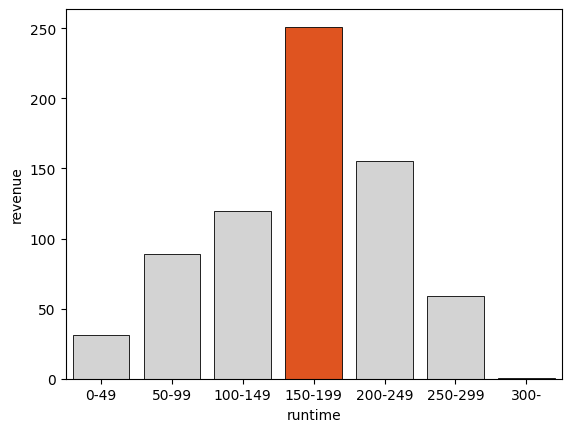

In [ ]:
y = [
    train.query('runtime>=0 and runtime<50').revenue.mean(),
     train.query('runtime>=50 and runtime<100').revenue.mean(),
     train.query('runtime>=100 and runtime<150').revenue.mean(),
     train.query('runtime>=150 and runtime<200').revenue.mean(),
     train.query('runtime>=200 and runtime<250').revenue.mean(),
     train.query('runtime>=250 and runtime<300').revenue.mean(),
     train.query('runtime>=300').revenue.mean()
]
x = [
    '0-49',
     '50-99',
     '100-149',
     '150-199',
     '200-249',
     '250-299',
     '300-'
]
palette = ['lightgrey', 'lightgrey', 'lightgrey', 'orangered', 'lightgrey', 'lightgrey', 'lightgrey']
sns.barplot(x=x, y=y, palette=palette, edgecolor='black', linewidth=.6)
plt.xlabel('runtime')
plt.ylabel('revenue')
plt.show();

##### 가설5. 예산을 많이 들이면 수익이 클 것이다

**세모** : 추세선을 보면 우상향하긴 하지만, 데이터의 분포가 커서 확신하기 어려움

예산의 분포는 right_skewed 형태

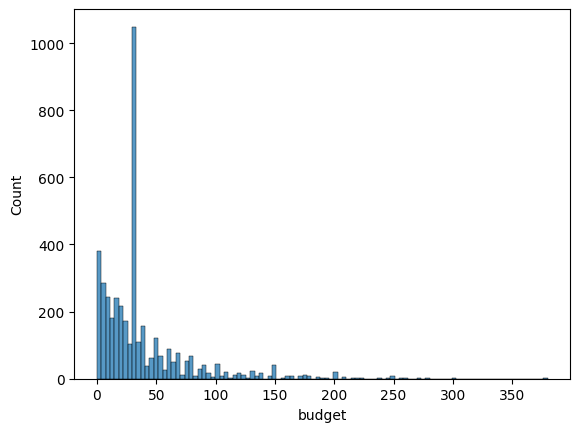

In [ ]:
sns.histplot(train.budget);

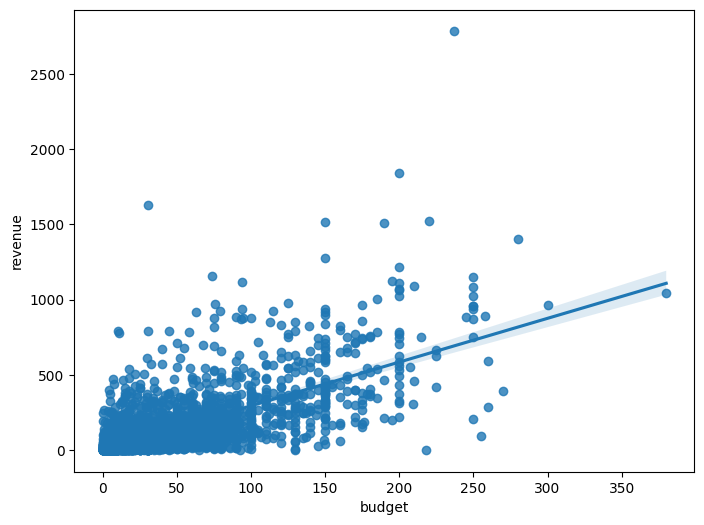

In [ ]:
plt.figure(figsize=(8,6))
sns.regplot(x=train.budget, y=train.revenue);

##### 가설6. 외출하기 좋은 계절(봄, 가을)에 수익이 클 것이다

**X** : 5-6월에 수익이 가장 큼

<ipython-input-93-98f6462dbd43>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(month_pivot.sort_values('revenue', ascending=False),x = 'month', y = 'revenue',palette=palette, edgecolor='black', linewidth=.4)


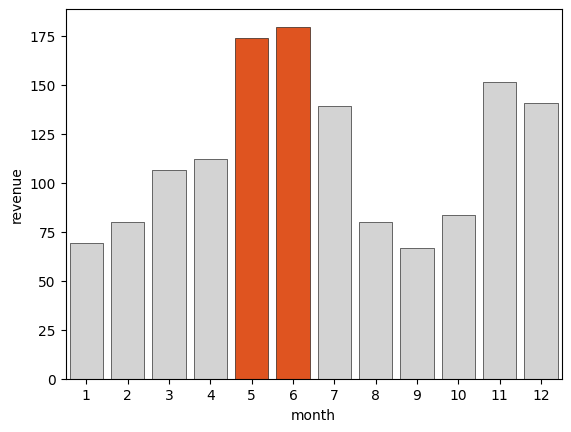

In [ ]:
month_pivot = pd.pivot_table(train,
                             index='month',
                             values='revenue',
                             aggfunc='mean')
month_pivot.reset_index(inplace=True)
palette = (['lightgrey']*4) + (['orangered']*2) + (['lightgrey']*6)
sns.barplot(month_pivot.sort_values('revenue', ascending=False),x = 'month', y = 'revenue',palette=palette, edgecolor='black', linewidth=.4)
plt.xlabel('month')
plt.show();

### 모델링

사용할 평가지표는 MAE

##### 데이터 나누기

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
X = train.drop(['revenue', 'genres'], axis=1)
y = train.revenue

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=2)

##### **기준모델** : 단순 선형 회귀 모델

In [ ]:
from sklearn.metrics import *

In [ ]:
y_base = [y_train.mean()] * len(y_train)
# 평가
print(f"기준모델의 학습 MAE:{mean_absolute_error(y_train, y_base)}")
print(f"기준모델의 학습 R2:{r2_score(y_train, y_base)}")

기준모델의 학습 MAE:89.98855900519915
기준모델의 학습 R2:0.0


In [ ]:
from sklearn.metrics import *
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2373 entries, 1159 to 3397
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   budget      2373 non-null   float64
 1   runtime     2373 non-null   int64  
 2   title       2373 non-null   int64  
 3   cast        2373 non-null   int64  
 4   month       2373 non-null   int64  
 5   genre_rank  2373 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 129.8 KB


In [ ]:
sim_ols = LinearRegression()

X_sim_tr, X_sim_val = X_train.loc[:,['budget']], X_val.loc[:,['budget']]

# 학습
sim_ols.fit(X_sim_tr, y_train)
# 예측
sim_pred_tr = sim_ols.predict(X_sim_tr)
sim_pred_val = sim_ols.predict(X_sim_val)
# 평가
print(f"단순선형회귀모델의 학습 MAE:{mean_absolute_error(y_train, sim_pred_tr)}")
print(f"단순선형회귀모델의 검증 MAE:{mean_absolute_error(y_val, sim_pred_val)}")
print('='*50)
print(f"단순선형회귀모델의 학습 R2:{r2_score(y_train, sim_pred_tr)}")
print(f"단순선형회귀모델의 검증 R2:{r2_score(y_val, sim_pred_val)}")

단순선형회귀모델의 학습 MAE:59.073017967867436
단순선형회귀모델의 검증 MAE:62.708197681419506
단순선형회귀모델의 학습 R2:0.45614502465531404
단순선형회귀모델의 검증 R2:0.5074076109513341


In [ ]:
sim_ols.coef_

array([2.8168495])

##### 다중 선형 회귀 모델

In [ ]:
scaler_s = StandardScaler()

features = ['budget', 'cast']

X_train_2 = scaler_s.fit_transform(X_train.loc[:, features])
X_val_2 = scaler_s.transform(X_val.loc[:, features])
# 모델 선언
mul_ols = LinearRegression()

# 학습
mul_ols.fit(X_train_2, y_train)
# 예측
mul_pred_tr = mul_ols.predict(X_train_2)
mul_pred_val = mul_ols.predict(X_val_2)
# 평가
print(f"다중선형회귀모델의 학습 MAE:{mean_absolute_error(y_train, mul_pred_tr)}")
print(f"다중선형회귀모델의 검증 MAE:{mean_absolute_error(y_val, mul_pred_val)}")
print('='*50)
print(f"다중선형회귀모델의 학습 R2:{r2_score(y_train, mul_pred_tr)}")
print(f"다중선형회귀모델의 검증 R2:{r2_score(y_val, mul_pred_val)}")

다중선형회귀모델의 학습 MAE:59.018385869271164
다중선형회귀모델의 검증 MAE:62.6489191567941
다중선형회귀모델의 학습 R2:0.4561606895701713
다중선형회귀모델의 검증 R2:0.5075420965807174


##### 다항회귀 모델

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
# 모델 선언
poly_ols = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
    )
 # 명목형 변수 제외
X_train_processed = scaler_s.fit_transform(X_train)
X_val_processed = scaler_s.transform(X_val)
# 학습
poly_ols.fit(X_train_processed, y_train)
# 예측
poly_pred_tr = poly_ols.predict(X_train_processed)
poly_pred_val = poly_ols.predict(X_val_processed)
# 평가
print(f"다항선형회귀모델의 학습 MAE:{mean_absolute_error(y_train, poly_pred_tr)}")
print(f"다항선형회귀모델의 검증 MAE:{mean_absolute_error(y_val, poly_pred_val)}")
print('='*50)
print(f"다항선형회귀모델의 학습 R2:{r2_score(y_train, poly_pred_tr)}")
print(f"다항선형회귀모델의 검증 R2:{r2_score(y_val, poly_pred_val)}")

다항선형회귀모델의 학습 MAE:60.27743232951001
다항선형회귀모델의 검증 MAE:65.63250023201284
다항선형회귀모델의 학습 R2:0.5084598941770437
다항선형회귀모델의 검증 R2:0.552888621530591


##### Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

In [ ]:
# Lasso regression
lasso_pipe = make_pipeline(
    StandardScaler(),
    Lasso()
)

# 학습
lasso_pipe.fit(X_train, y_train)
# 예측
lasso_pred_tr = lasso_pipe.predict(X_train)
lasso_pred_val = lasso_pipe.predict(X_val)
# 평가
print(f"lasso모델의 학습 MAE:{mean_absolute_error(y_train, lasso_pred_tr)}")
print(f"lasso모델의 검증 MAE:{mean_absolute_error(y_val, lasso_pred_val)}")
print('='*50)
print(f"lasso모델의 학습 R2:{r2_score(y_train, lasso_pred_tr)}")
print(f"lasso모델의 검증 R2:{r2_score(y_val, lasso_pred_val)}")

lasso모델의 학습 MAE:61.98171168478929
lasso모델의 검증 MAE:65.84805395421647
lasso모델의 학습 R2:0.466230542628271
lasso모델의 검증 R2:0.5146484883023825


##### randomforest regressor

해당 모델을 튜닝하기로 결정

In [ ]:
from sklearn.ensemble import RandomForestRegressor
pipe_rf = make_pipeline(
    # OrdinalEncoder(),
    # StandardScaler(),
    RandomForestRegressor(
        criterion='absolute_error',
        max_depth=5,
        min_samples_leaf=8,
        random_state=42,
        n_estimators=150,
        oob_score=True,
    )
)
# 학습
pipe_rf.fit(X_train, y_train)
# 예측
rf_pred_tr = pipe_rf.predict(X_train)
rf_pred_val = pipe_rf.predict(X_val)
# 평가
print(f"rf모델의 학습 MAE:{mean_absolute_error(y_train, rf_pred_tr)}")
print(f"rf모델의 검증 MAE:{mean_absolute_error(y_val, rf_pred_val)}")
print('='*50)
print(f"rf모델의 학습 R2:{r2_score(y_train, rf_pred_tr)}")
print(f"rf모델의 검증 R2:{r2_score(y_val, rf_pred_val)}")

rf모델의 학습 MAE:50.82342160405255
rf모델의 검증 MAE:60.92641259320708
rf모델의 학습 R2:0.5007844712386993
rf모델의 검증 R2:0.4943766164814032


##### XGBoost regressor


In [ ]:
from xgboost import XGBRegressor
pipe_xgb = make_pipeline(
    # OrdinalEncoder(),
    # StandardScaler(),
    XGBRegressor(
        max_depth=2,
        random_state=42
    )
)
# 학습
pipe_xgb.fit(X_train, y_train)
# 예측
xgb_pred_tr = pipe_xgb.predict(X_train)
xgb_pred_val = pipe_xgb.predict(X_val)
# 평가
print(f"xgb모델의 학습 MAE:{mean_absolute_error(y_train, xgb_pred_tr)}")
print(f"xgb모델의 검증 MAE:{mean_absolute_error(y_val, xgb_pred_val)}")
print('='*50)
print(f"xgb모델의 학습 R2:{r2_score(y_train, xgb_pred_tr)}")
print(f"xgb모델의 검증 R2:{r2_score(y_val, xgb_pred_val)}")

xgb모델의 학습 MAE:53.12427208529223
xgb모델의 검증 MAE:67.00801268169752
xgb모델의 학습 R2:0.6497798826386112
xgb모델의 검증 R2:0.5342060940448685


##### randomforest regressor 하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
params = {
    "randomforestregressor__max_depth": np.arange(2,6,1),
    "randomforestregressor__min_samples_leaf": np.arange(1,10,1),
    "randomforestregressor__min_samples_split": np.arange(1,10,1),
    "randomforestregressor__n_estimators":np.arange(50,350,50),
    "randomforestregressor__criterion": ['absolute_error', 'squared_error']
    }
randomized_search = RandomizedSearchCV(
    pipe_rf,
    param_distributions=params,
    scoring="neg_mean_absolute_error",
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 MAE: ", -randomized_search.best_score_)

최적 하이퍼파라미터:  {'randomforestregressor__n_estimators': 50, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__max_depth': 5, 'randomforestregressor__criterion': 'absolute_error'}
최적 MAE:  54.406326192434086


In [ ]:
param_grid = {
    "randomforestregressor__max_depth": [4,5,6],
    "randomforestregressor__min_samples_leaf": [3,4,5],
    "randomforestregressor__min_samples_split": [3,4,5],
    "randomforestregressor__n_estimators":[25,50,75],
}
grid_search = GridSearchCV(
    pipe_rf,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5
)
grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 MAE: ", -grid_search.best_score_)

최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 6, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__n_estimators': 75}
최적 MAE:  53.95239458961591


In [ ]:
param_grid = {
    "randomforestregressor__max_depth": [6,7,8],
    "randomforestregressor__min_samples_leaf": [5,6,7],
    "randomforestregressor__min_samples_split": [2,3],
    "randomforestregressor__n_estimators":[75, 90, 100],
}
grid_search = GridSearchCV(
    pipe_rf,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5
)
grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 MAE: ", -grid_search.best_score_)


최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 6, 'randomforestregressor__min_samples_leaf': 7, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100}
최적 MAE:  53.85351433030687


In [ ]:
gr_val_pred = grid_search.predict(X_val)
print(f"gr1모델의 검증 MAE: {mean_absolute_error(y_val, gr_val_pred)}")

gr1모델의 검증 MAE: 60.11268268702021


In [ ]:
param_grid = {
    "randomforestregressor__max_depth": [8,9,10],
    "randomforestregressor__min_samples_leaf": [7,8,9],
    "randomforestregressor__n_estimators":[100, 125, 150],
}
grid_search2 = GridSearchCV(
    pipe_rf,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5
)

grid_search2.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", grid_search2.best_params_)
print("최적 MAE: ", -grid_search2.best_score_)

최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 9, 'randomforestregressor__min_samples_leaf': 9, 'randomforestregressor__n_estimators': 150}
최적 MAE:  53.8984501479125


In [ ]:
gr2_val_pred = grid_search2.predict(X_val)
print(f"gr2모델의 검증 MAE: {mean_absolute_error(y_val, gr2_val_pred)}")

gr2모델의 검증 MAE: 59.97605384069025


In [ ]:
param_grid = {
    "randomforestregressor__min_samples_leaf": [9,10,11,12],
    "randomforestregressor__n_estimators":[150, 200, 250, 300],
}

grid_search3 = GridSearchCV(
    pipe_rf,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5
)

grid_search3.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", grid_search3.best_params_)
print("최적 MAE: ", -grid_search3.best_score_)


최적 하이퍼파라미터:  {'randomforestregressor__min_samples_leaf': 9, 'randomforestregressor__n_estimators': 200}
최적 MAE:  54.13518794481022


In [ ]:
gr3_val_pred = grid_search3.predict(X_val)
gr3_train_pred = grid_search3.predict(X_train)
print(f"gr3모델의 검증 MAE: {mean_absolute_error(y_val, gr3_val_pred)}")
print('='*45)
print(f"gr3모델의 학습 R2: {r2_score(y_train,gr3_train_pred)}")
print(f"gr3모델의 검증 R2: {r2_score(y_val, gr3_val_pred)}")

gr3모델의 검증 MAE: 60.76509968934975
gr3모델의 학습 R2: 0.5027768588316173
gr3모델의 검증 R2: 0.4934449496588883


##### 특성중요도 확인 컬럼 select

In [ ]:
grid_search3.best_estimator_[0]

RandomForestRegressor(criterion='absolute_error', max_depth=5,
                      min_samples_leaf=9, n_estimators=200, oob_score=True,
                      random_state=42)

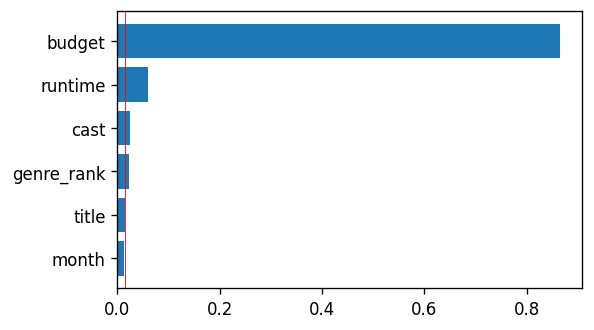

In [ ]:
# MDI
feature_importances = list(
    zip(list(X_train), grid_search3.best_estimator_[0].feature_importances_)
)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(5, 3), dpi=120)
plt.barh(*list(zip(*feature_importances[::-1])))
plt.axvline(0.015, color="red", linewidth=0.5);


In [ ]:
! pip install eli5

In [ ]:
# permutation importances
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter_rf = PermutationImportance(
    grid_search3.best_estimator_[0],  # model
    scoring="neg_mean_absolute_error",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=42,
)
# 스코어를 다시 계산합니다.
permuter_rf.fit(X_val, y_val)

PermutationImportance(estimator=RandomForestRegressor(criterion='absolute_error',
                                                      max_depth=5,
                                                      min_samples_leaf=9,
                                                      n_estimators=200,
                                                      oob_score=True,
                                                      random_state=42),
                      n_iter=10, random_state=42,
                      scoring='neg_mean_absolute_error')

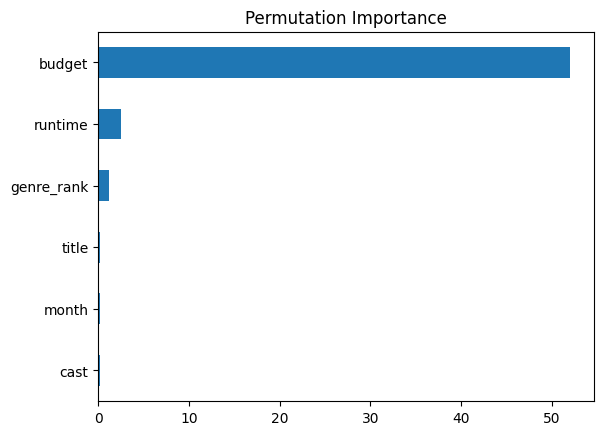

In [ ]:
feature_names =list(X)
pi = pd.Series(permuter_rf.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance");

In [ ]:
model = RandomForestRegressor(
    criterion='absolute_error',
    max_depth=9,
    min_samples_leaf=9,
    n_estimators=200,
    random_state=42
)
select_features = ['budget', 'runtime', 'genre_rank', 'month']
X_train_selected = X_train.loc[:,select_features]
X_val_selected = X_val.loc[:, select_features]
# 학습
model.fit(X_train_selected, y_train)
# 예측
model_pred_tr = model.predict(X_train_selected)
model_pred_val = model.predict(X_val_selected)
# 평가
print(f"컬럼 선택한 모델의 학습 MAE: {mean_absolute_error(y_train,model_pred_tr)}")
print(f"컬럼 선택한 모델의 검증 MAE: {mean_absolute_error(y_val, model_pred_val)}")
print('='*45)
print(f"컬럼 선택한 모델의 학습 R2: {r2_score(y_train,model_pred_tr)}")
print(f"컬럼 선택한 모델의 검증 R2: {r2_score(y_val, model_pred_val)}")

컬럼 선택한 모델의 학습 MAE: 48.32276836087022
컬럼 선택한 모델의 검증 MAE: 59.89772141518625
컬럼 선택한 모델의 학습 R2: 0.5387860194242349
컬럼 선택한 모델의 검증 R2: 0.5177447346220259


##### 컬럼 select 후 다시 파라미터 튜닝

In [ ]:
param_grid = {
    "max_depth": [12,13,14,15],
    "min_samples_leaf": [8,9,10,11],
}
gs_model = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5
)
gs_model.fit(X_train_selected, y_train)
print("최적 하이퍼파라미터: ", gs_model.best_params_)
print("최적 MAE: ", -gs_model.best_score_)
modelgs_train_pred = gs_model.predict(X_train_selected)
modelgs_val_pred = gs_model.predict(X_val_selected)
print(f"gs_model모델의 검증 MAE: {mean_absolute_error(y_val, modelgs_val_pred)}")
print('='*50)
print(f"rf모델의 학습 R2:{r2_score(y_train, modelgs_train_pred)}")
print(f"rf모델의 검증 R2:{r2_score(y_val, modelgs_val_pred)}")

최적 하이퍼파라미터:  {'max_depth': 13, 'min_samples_leaf': 8}
최적 MAE:  54.126527526286296
gs_model모델의 검증 MAE: 59.65791139707073
rf모델의 학습 R2:0.550662609505167
rf모델의 검증 R2:0.5220966058669392


In [ ]:
# permuter 정의
permuter_model = PermutationImportance(
    gs_model.best_estimator_,  # model
    scoring="neg_mean_absolute_error",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=42,
)
# 스코어를 다시 계산합니다.
permuter_model.fit(X_val_selected, y_val)

PermutationImportance(estimator=RandomForestRegressor(criterion='absolute_error',
                                                      max_depth=13,
                                                      min_samples_leaf=8,
                                                      n_estimators=200,
                                                      random_state=42),
                      n_iter=10, random_state=42,
                      scoring='neg_mean_absolute_error')

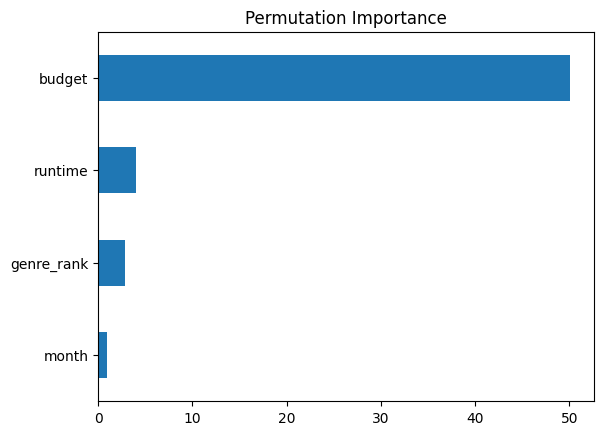

In [ ]:
feature_names =list(X_val_selected)
pi = pd.Series(permuter_model.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance");

##### 일반화 성능 확인

In [ ]:
# 일반화 성능 확인
X_test_selected = X_test.loc[:, select_features]
modelgs_test_pred = gs_model.predict(X_test_selected)
print(f"최종모델의 일반화 MAE: {mean_absolute_error(y_test, modelgs_test_pred)}")
print('='*40)
print(f"최종모델의 일반화 R2: {r2_score(y_test, modelgs_test_pred)}")

최종모델의 일반화 MAE: 54.68174074997871
최종모델의 일반화 R2: 0.5049798927258908


#### pdp로 가설 확인하기

In [ ]:
X_val_selected = X_val.loc[:, select_features]
X_val_selected.columns

Index(['budget', 'runtime', 'genre_rank', 'month'], dtype='object')

In [ ]:
! pip3 install pdpbox

In [ ]:
import logging # PDPIsolate.plot waring문구 없애기
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

obtain pred_func from the provided model.


  0%|          | 0/9 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/8 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

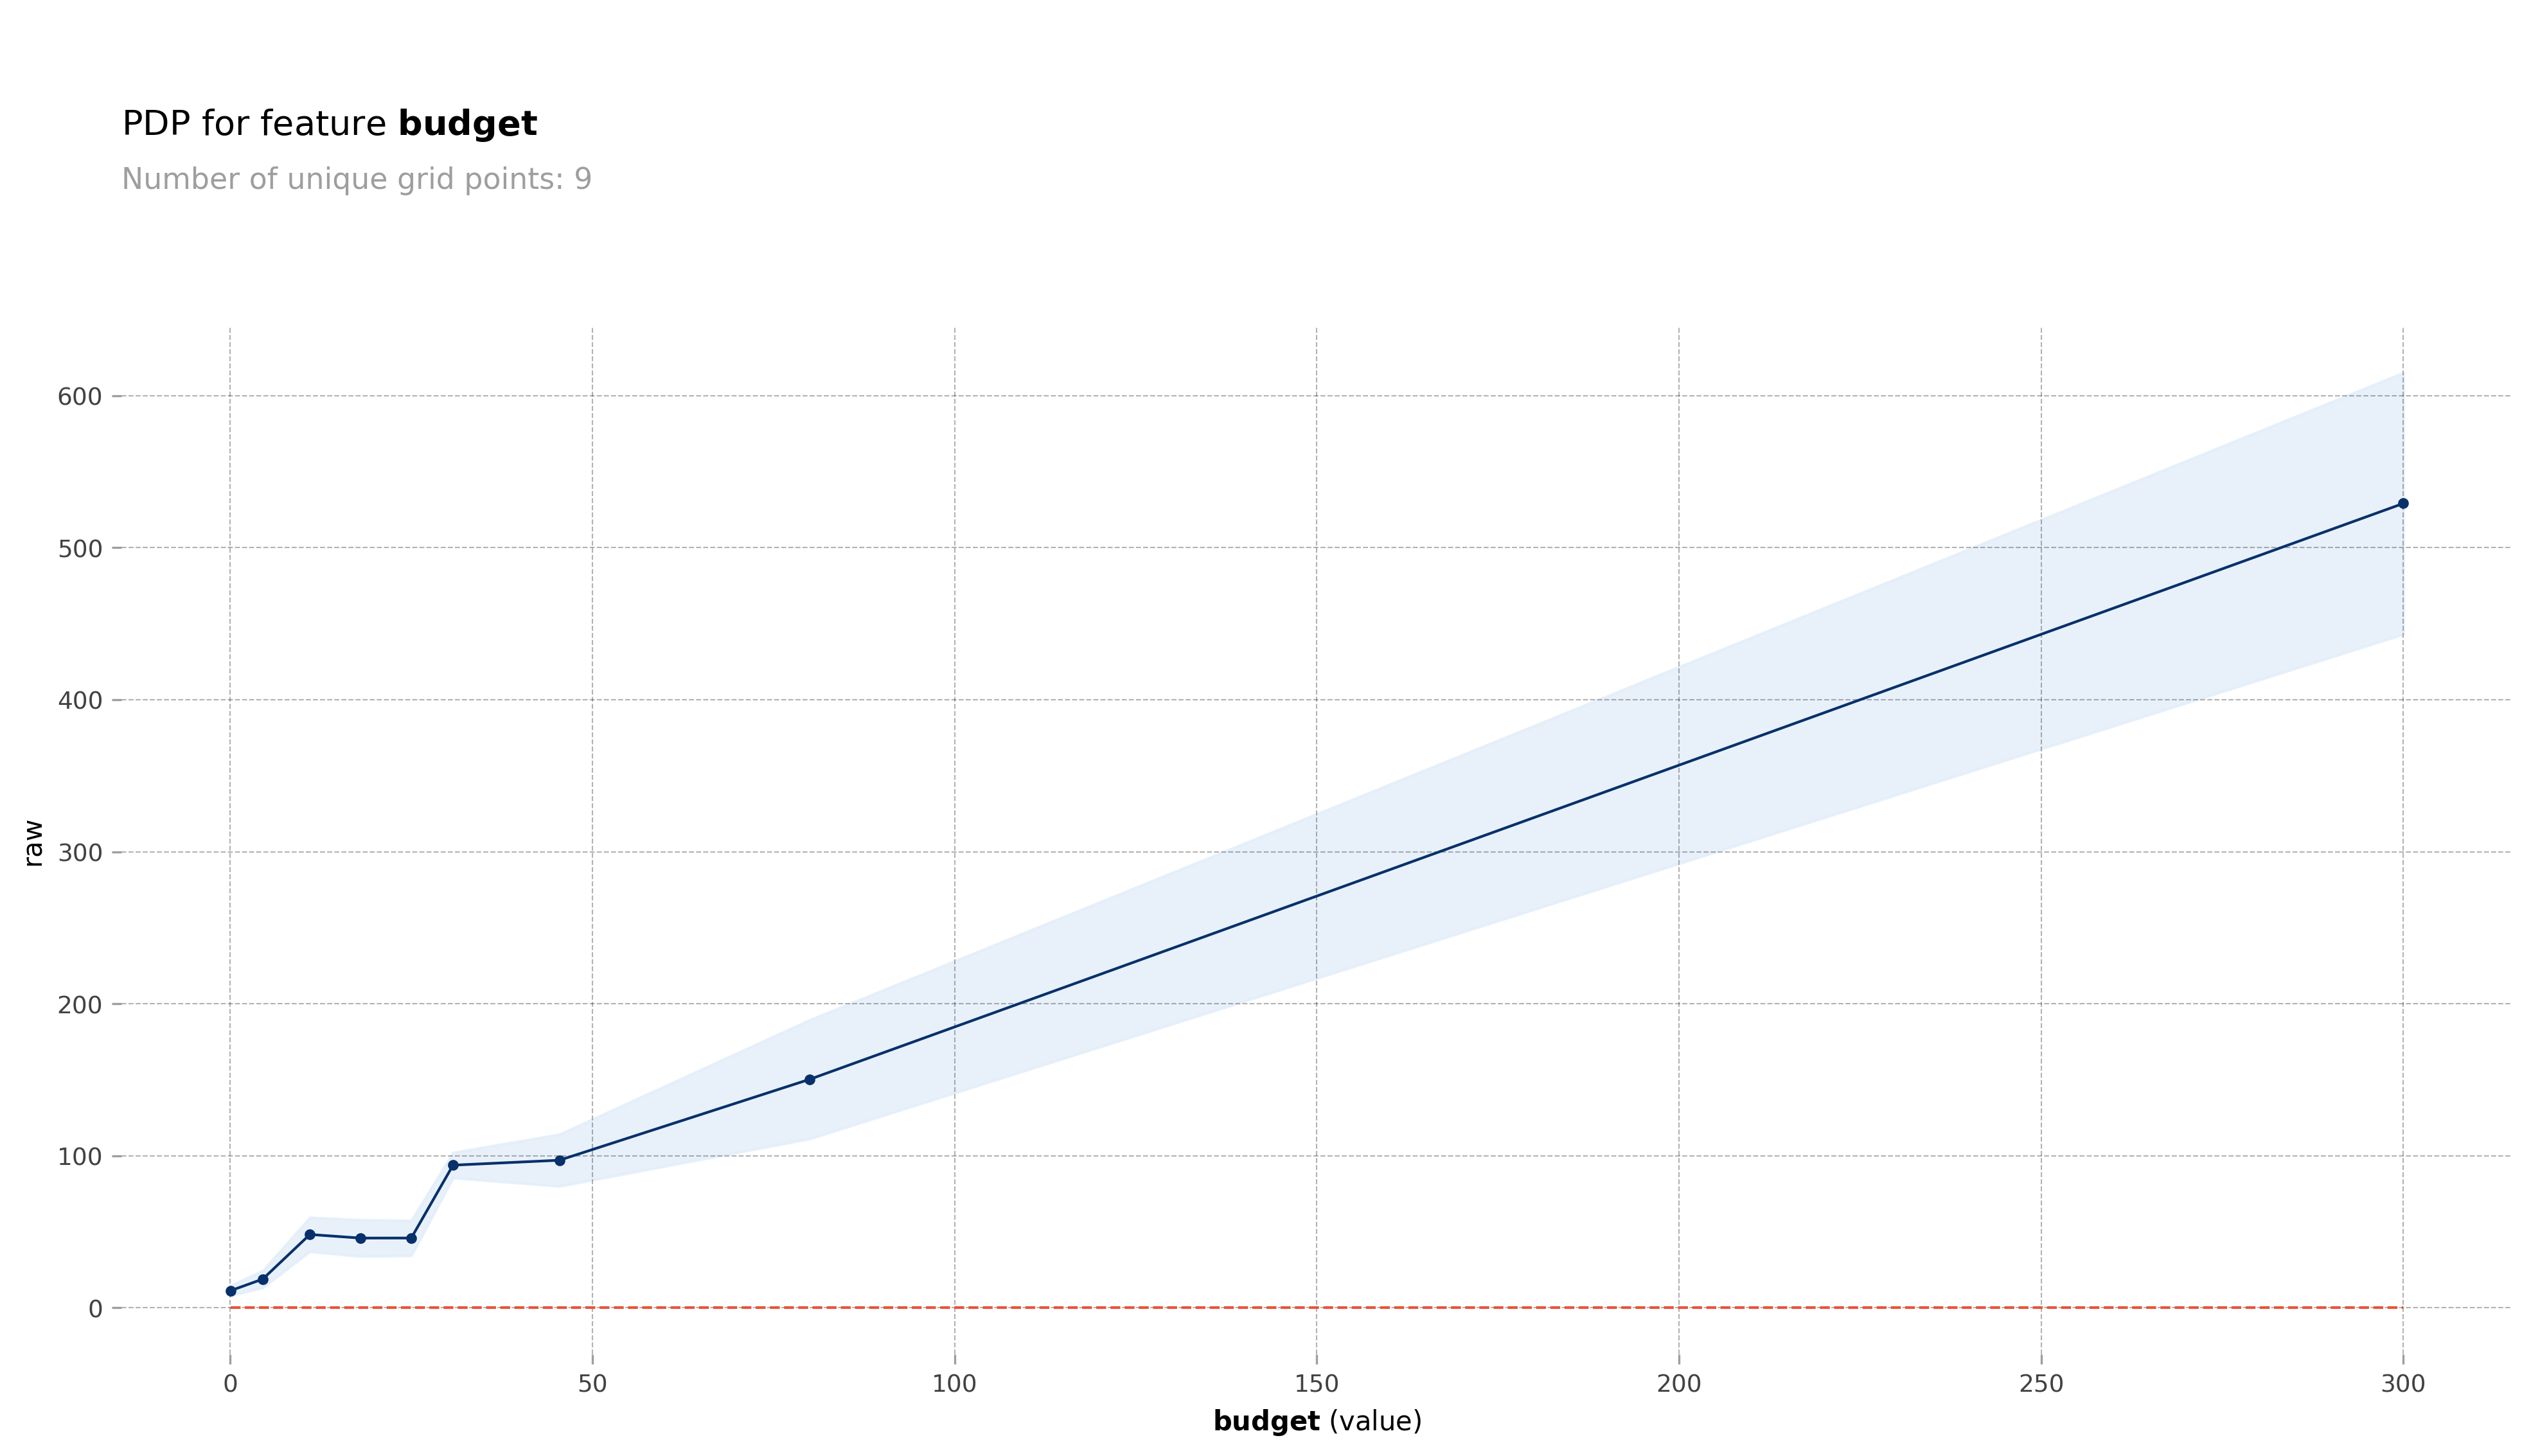

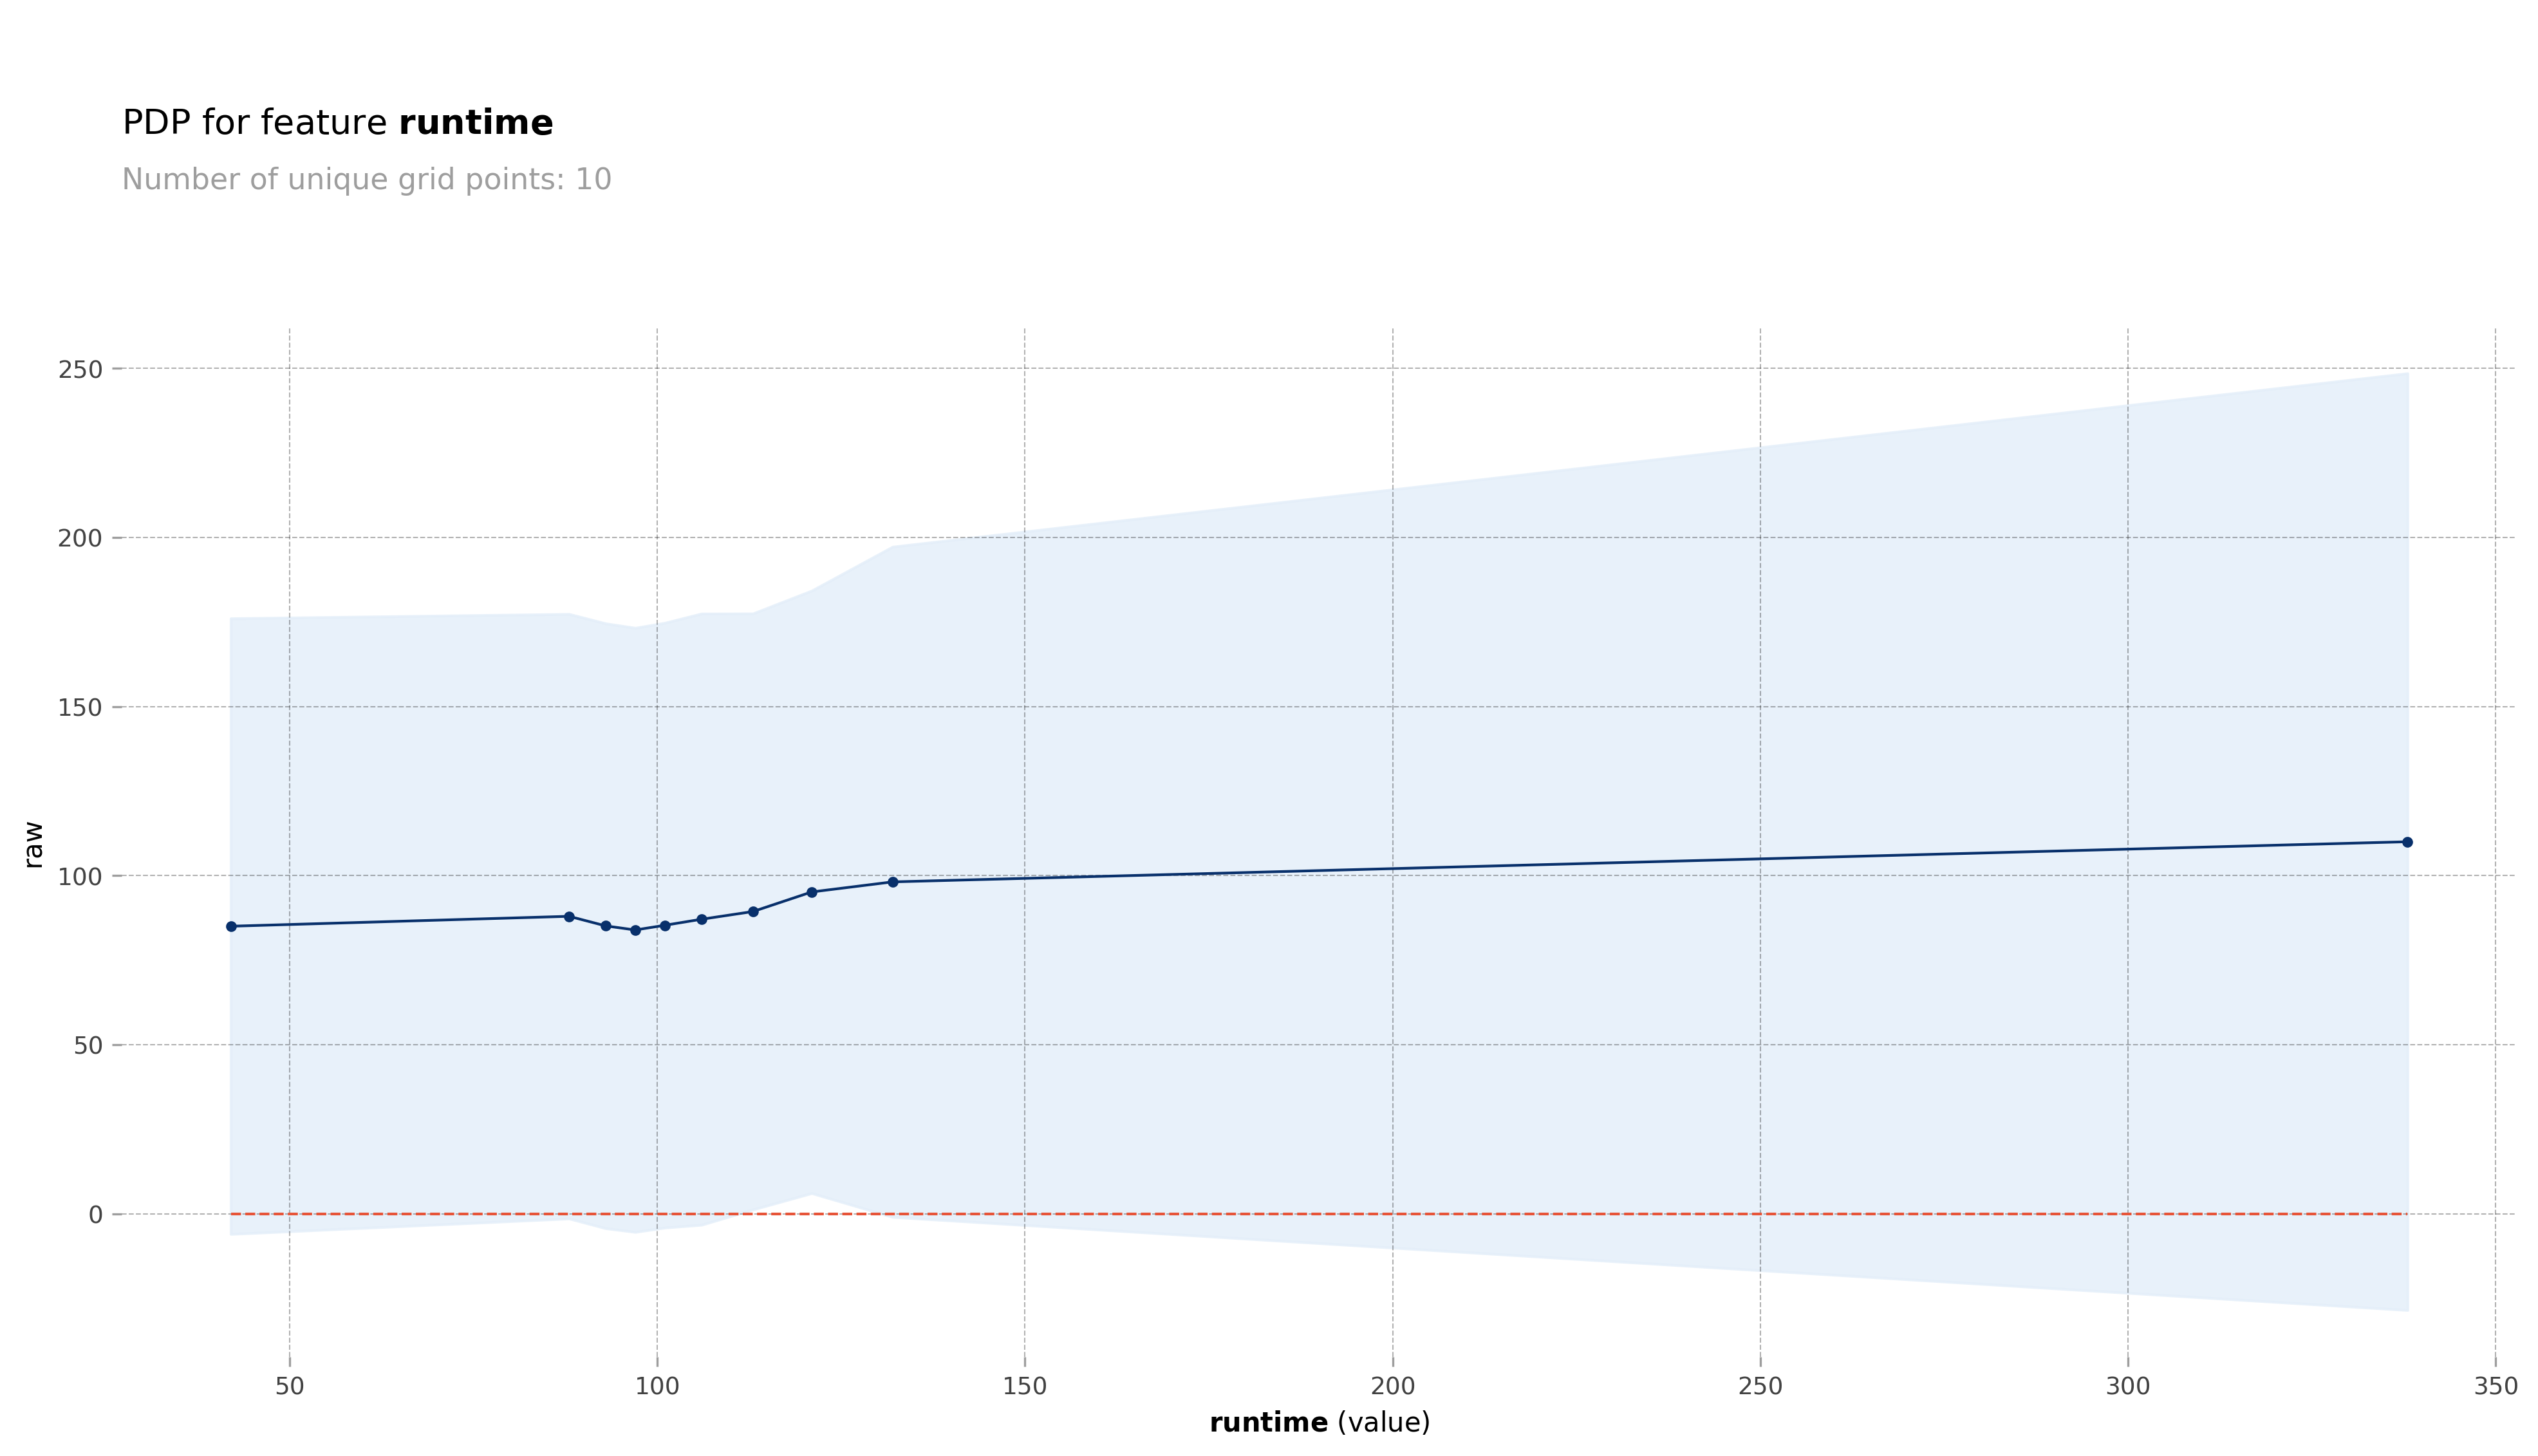

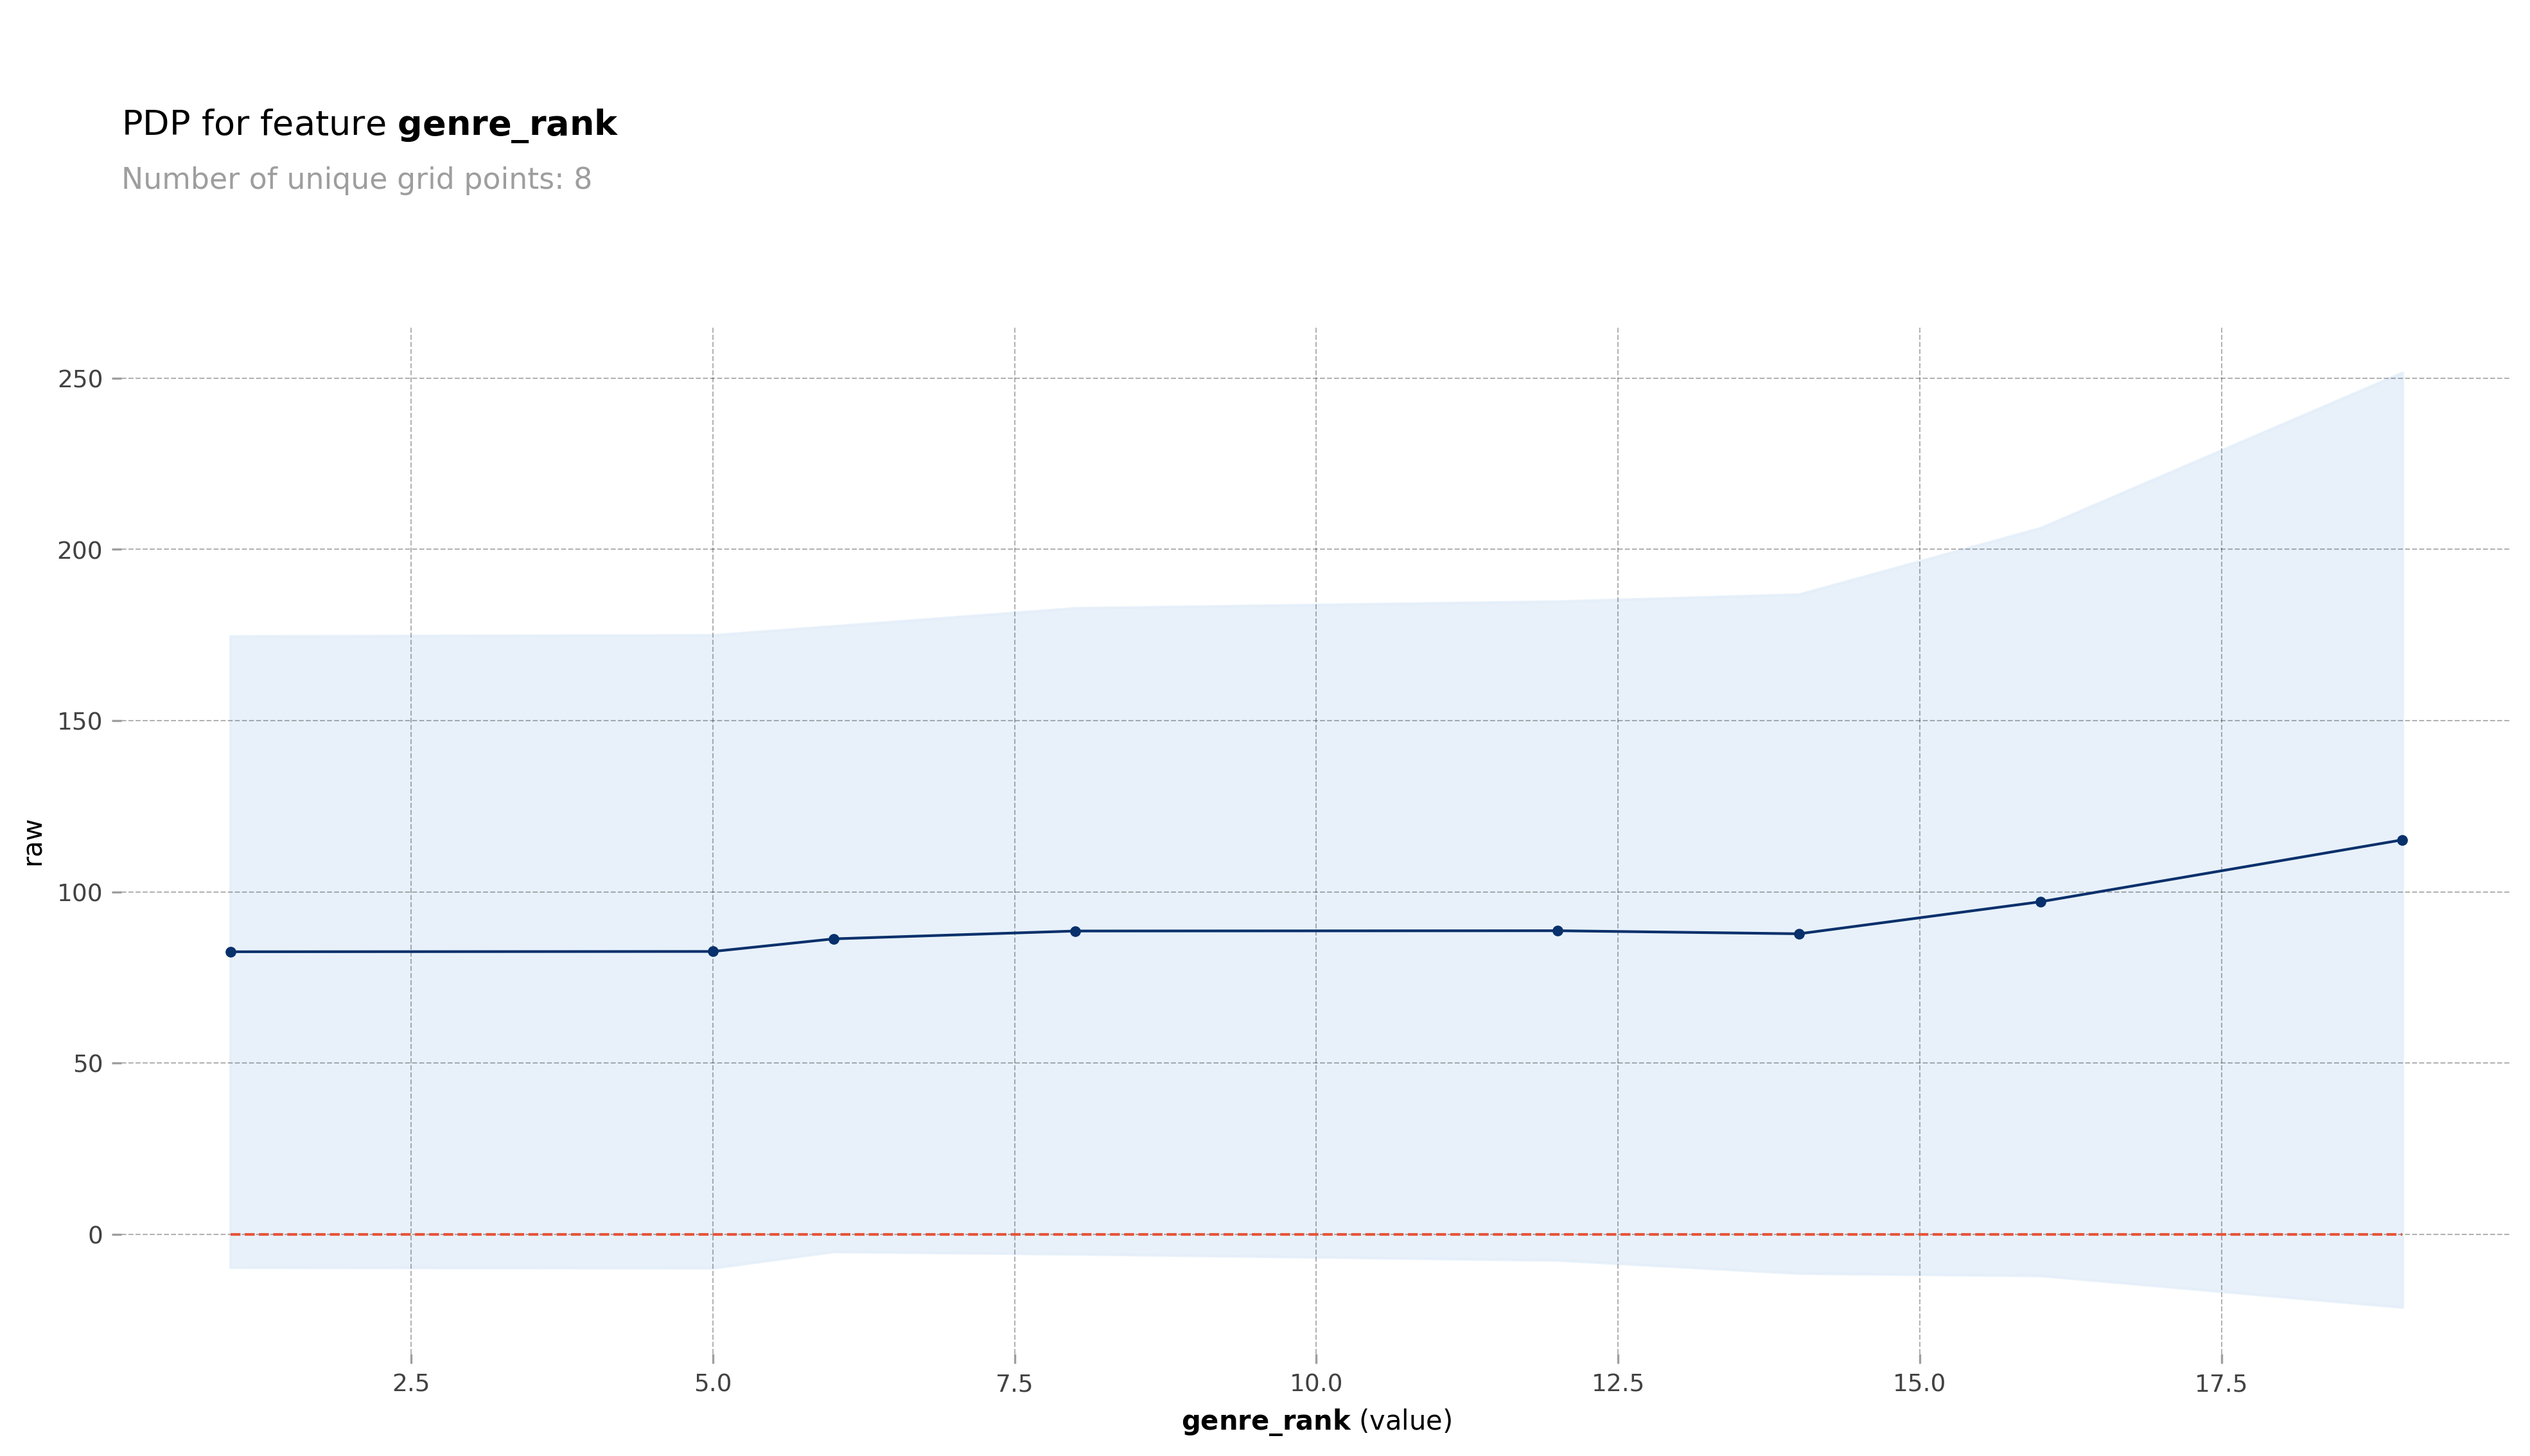

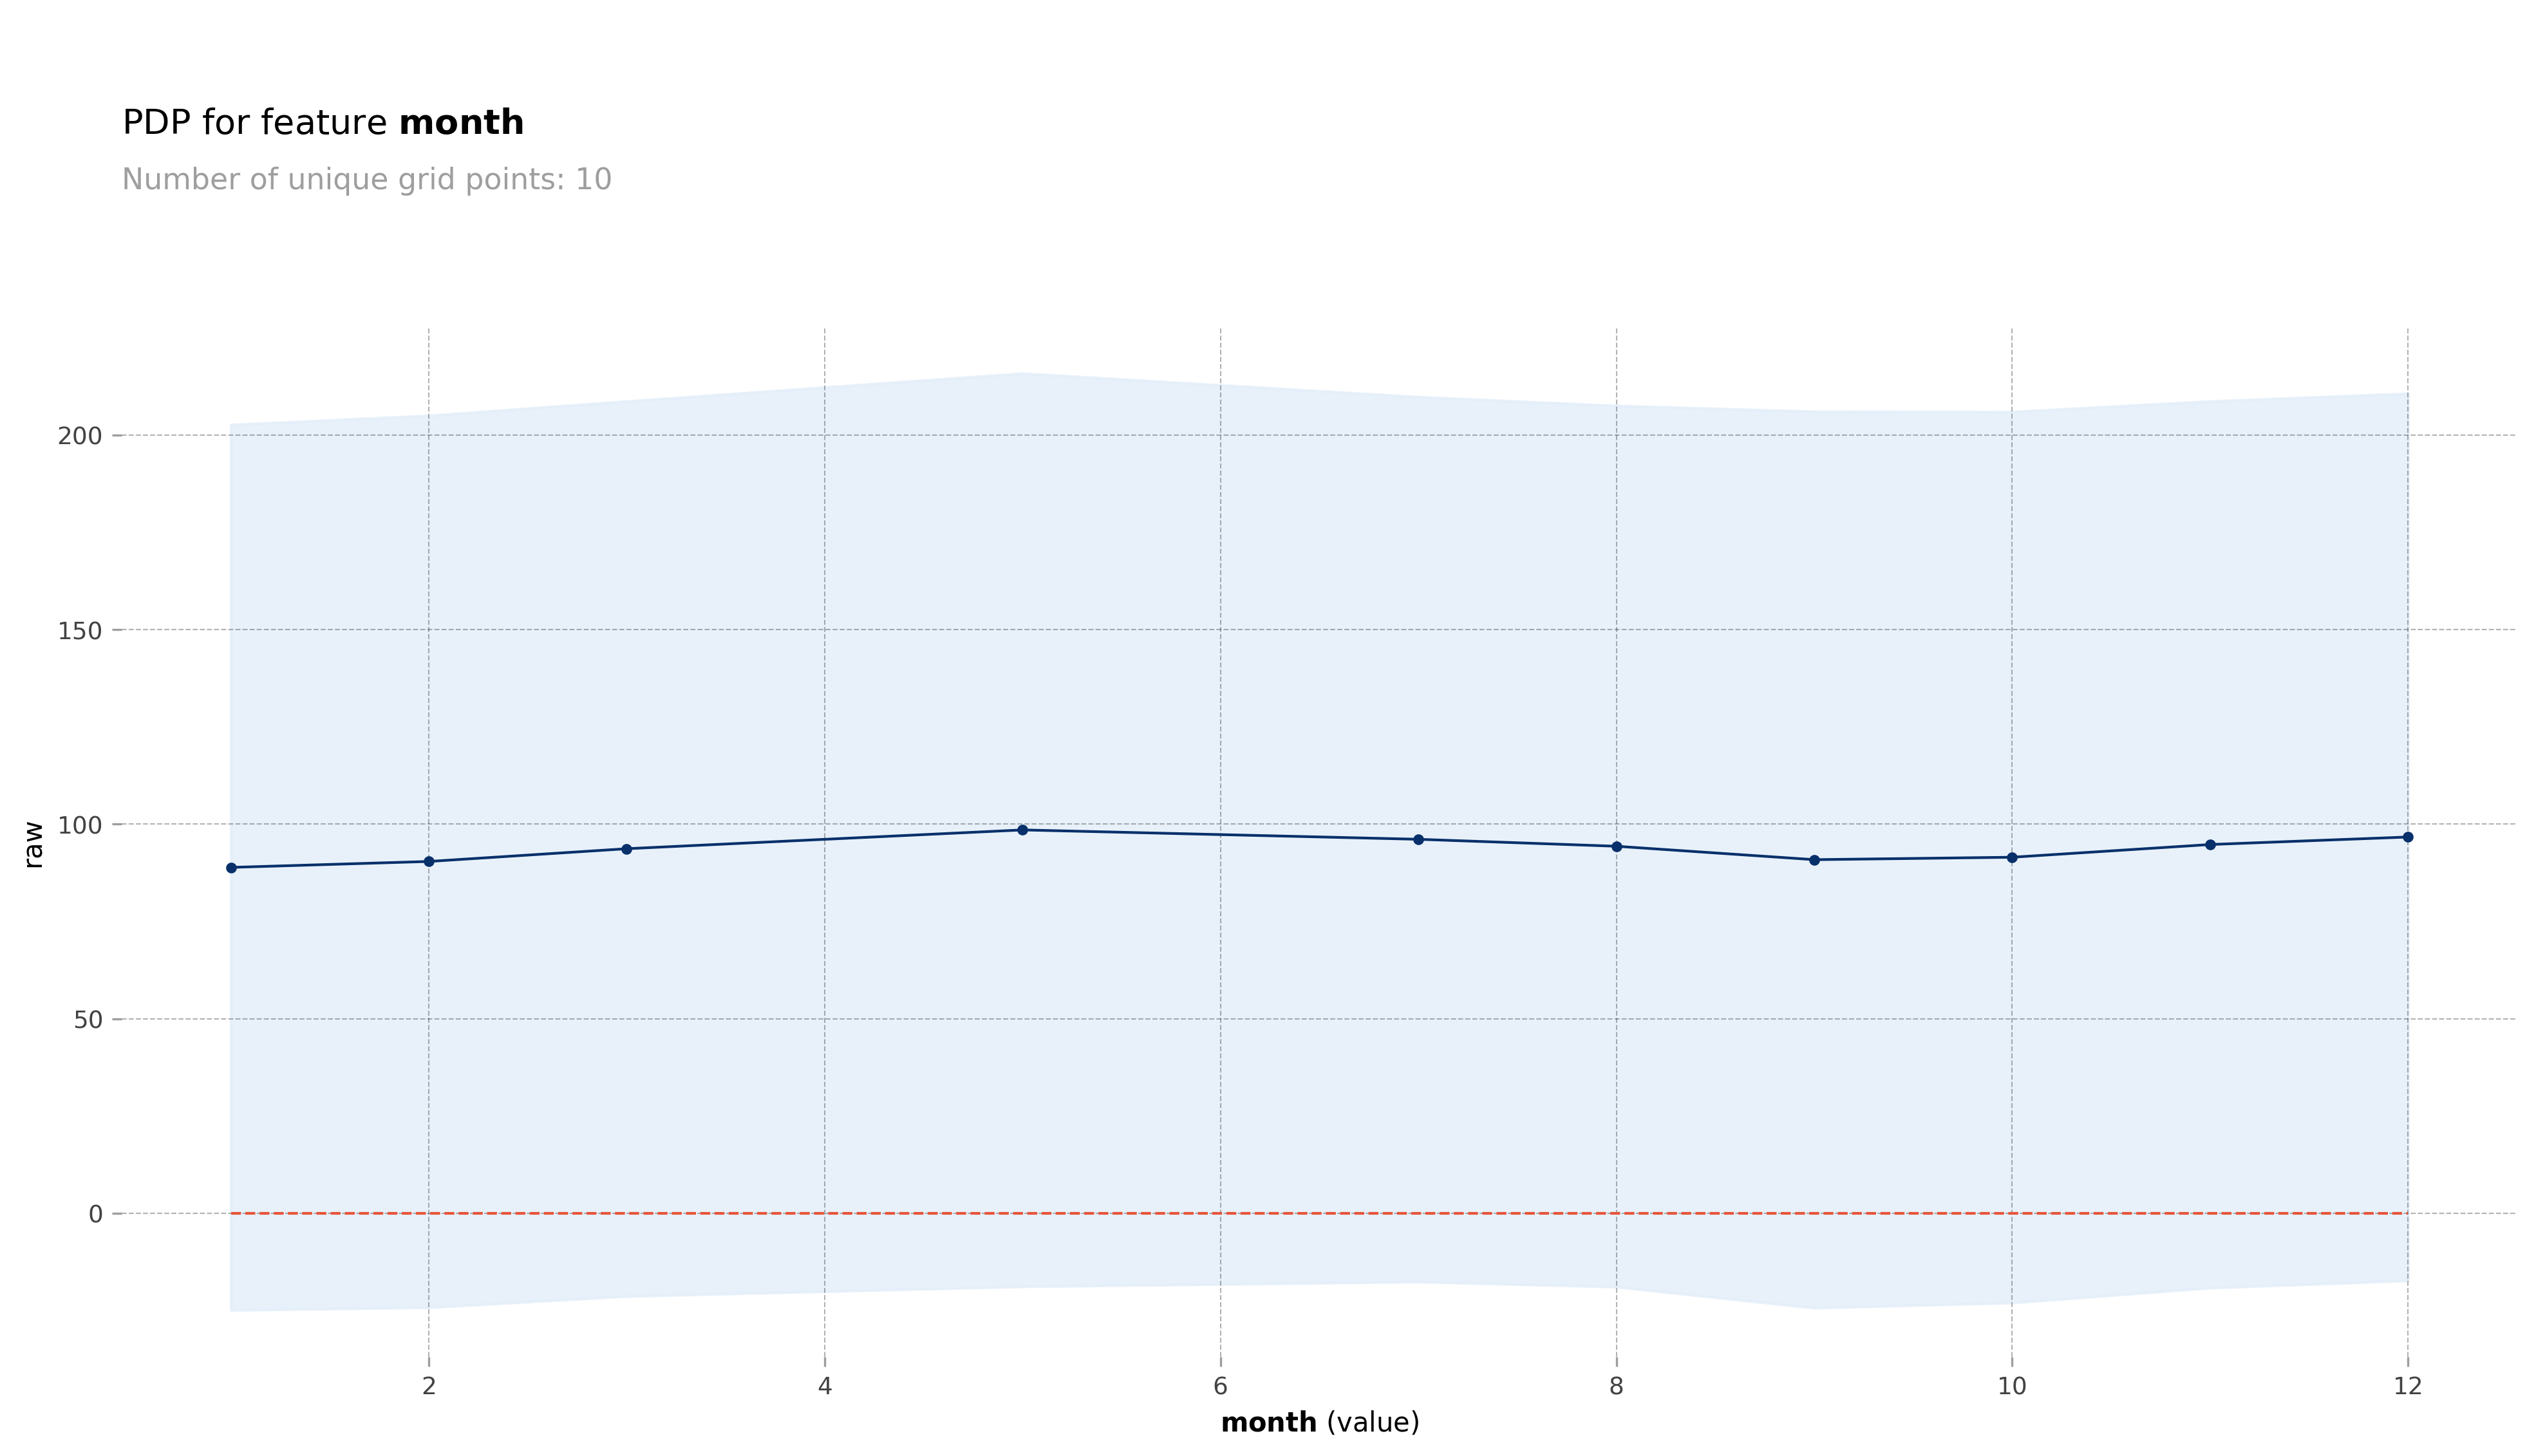

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from pdpbox.pdp import PDPIsolate
plt.rcParams["figure.dpi"] = 144
target_feature = ['budget', 'runtime', 'genre_rank', 'month']
for feature in target_feature:
  isolated = PDPIsolate(
      model=gs_model,
      df=X_val_selected,
      model_features=target_feature,
      feature=feature,
      n_classes=0,
      feature_name=feature
      # grid_type="percentile",  # default = 'percentile', or 'equal'
      # num_grid_points=10,  # default = 10
  )
  fig, axes = isolated.plot(
      center=False,
      plot_lines=False,
      plot_pts_dist=False,
      to_bins=False,
      engine='matplotlib',
  )
  # fig.set_figheight(5)

### 문제 해결:제작영화 고르기, 여건 조정하기

In [ ]:
# 미래데이터중 10개의 데이터를 뽑아 수익을 예측하고, 수익을 높이려면 어떤 조정이 필요할지 결론내기.(ice_plot)
movie_sample = movie_list.sample(10, random_state=3)
movie_sample = movie_sample.loc[:, select_features]
movie_sample
movie_sample['rev_predict'] = gs_model.predict(movie_sample)
movie_sample.reset_index(drop=True, inplace=True)

##### sample 별 ICE plot 확인

In [ ]:
def get_ice_plot_data(data, data_index, target_feature, target_feature_range):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []

    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred = gs_model.predict(one_datapoint)
        results.append(one_datapoint_pred)
    results = np.array(results)
    return target_feature_range, results - results[0]

In [ ]:
movie_sample

,budget,runtime,genre_rank,month,rev_predict
0,55.000,107,8,6,132.816
1,9.000,96,12,11,20.583
2,8.000,135,14,12,23.038
3,0.250,96,5,11,3.339
4,1.900,89,5,4,12.222
5,0.600,83,8,8,15.739
6,15.600,91,8,6,45.170
7,20.000,101,2,12,33.564
8,1.596,75,6,2,18.218
9,26.000,90,8,12,62.550


인덱스6번 작품의 상영시간을 약 2시간으로 늘리면 수익을 늘릴 수 있을 거라 예상

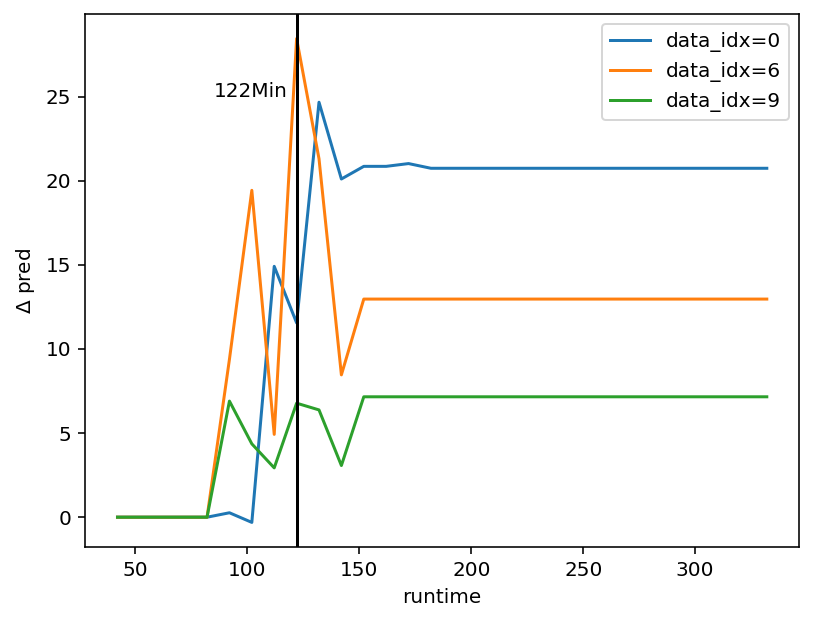

In [ ]:
target_feature = 'runtime'
target_feature_range = np.arange(int(X_val_selected[target_feature].min().round()), int(X_val_selected[target_feature].max().round())+ 1, 10)
for data_index in [0, 6, 9]:
    plt.plot(
        *get_ice_plot_data(movie_sample.drop('rev_predict', axis=1), data_index, target_feature, target_feature_range),
        label=f"data_idx={data_index}"
    )

plt.xlabel(target_feature)
plt.ylabel("$\Delta$ pred")
plt.axvline(122, color='black')
plt.text(85, 25, '122Min')
plt.legend(loc='upper right');


인덱스0번 작품의 개봉을 5월로 앞당기면 높을 수익을 얻을 것으로 예상

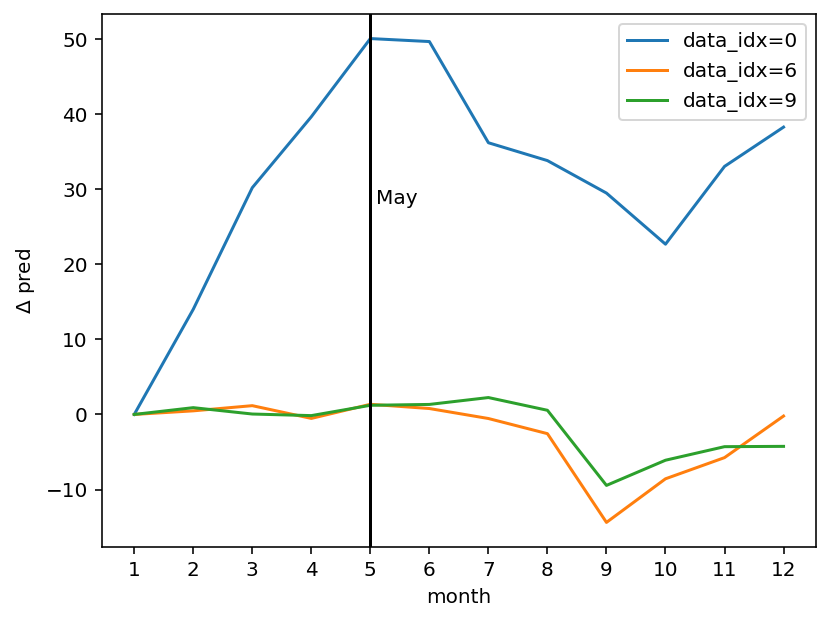

In [ ]:
target_feature = 'month'
target_feature_range = np.arange(int(X_val_selected[target_feature].min().round()), int(X_val_selected[target_feature].max().round())+ 1, 1)
for data_index in [0, 6, 9]:
    plt.plot(
        *get_ice_plot_data(movie_sample.drop('rev_predict', axis=1), data_index, target_feature, target_feature_range),
        label=f"data_idx={data_index}"
    )

plt.xlabel(target_feature)
plt.xticks(np.arange(1,13,1))
plt.ylabel("$\Delta$ pred")
plt.axvline(5, color='black')
plt.text(5.1, 28, 'May')
plt.legend();